# Importamos librerias y funciones nuestras

### Librerias

In [571]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from importlib import reload
import pandas as pd
import sympy as sp
from scipy.optimize import curve_fit
plt=reload(plt)

### Funciones

#### Coeficiente de Person

In [572]:
def coef_person(N, xi, yi):
    numerador_cp = ((N * (np.sum(xi * yi))) - (np.sum(xi) * np.sum(yi))) **2
    denominador_cp = ((N * np.sum(xi**2)) - (np.sum(xi))**2) * ((N * np.sum(yi**2)) - (np.sum(yi))**2)
    return np.sqrt(numerador_cp / denominador_cp)

#### Leer los archivos txt

In [573]:
def fuerzas(nombre_archivo):
    f = open(f"{nombre_archivo}.txt",'r')
    lines = f.readlines()[4:-1]

    tiempo = [] #segundos
    newtons = []

    for line in lines:
        tiempo.append(float(line.split("\t")[0].replace(',', '.')))
        newtons.append(float(line.split("\t")[1].split("\n")[0].replace(',', '.')))

    tiempo = np.array(tiempo)
    newtons = np.array(newtons)

    return tiempo, newtons

#### Cuadrados Mínimos Ponderados

In [574]:
#definimos el parametro a
def a(xi, yi, sigma_yi):
    wi = 1 / (sigma_yi**2)
    numerador_a = (np.sum(wi) * np.sum(xi * yi * wi)) - ((np.sum(xi * wi)) * (np.sum(yi * wi))) 
    denominador_a = (np.sum(wi) * np.sum(wi * (xi**2)) - (np.sum(wi * xi)**2))
    return (numerador_a / denominador_a)

#definimos el parametro b
def b(xi,yi, sigma_yi):
    wi = 1 / (sigma_yi**2)
    numerador_b = (np.sum(wi * (xi**2))) * (np.sum(wi * yi)) - (np.sum(xi * wi) * np.sum(xi * yi * wi))
    denominador_b = (np.sum(wi) * np.sum(wi * (xi**2)) - (np.sum(wi * xi)**2))
    return numerador_b / denominador_b 

#definimos f(xi)= axi + b
def f(xi,yi,sigma_yi): return a(xi,yi,sigma_yi)* xi + b(xi,yi,sigma_yi)

#definimos sigmas de a y b
def sigma_a(xi,yi,sigma_yi):
    wi = 1 / (sigma_yi**2)
    denominador_a = (np.sum(wi) * np.sum(wi * (xi**2)) - (np.sum(wi * xi)**2))
    radicando = (np.sum(wi)) / (denominador_a)
    return np.sqrt(radicando)

def sigma_b(xi,yi,sigma_yi):
    wi = 1 / (sigma_yi**2)
    denominador_b = (np.sum(wi) * np.sum(wi * (xi**2)) - (np.sum(wi * xi)**2))
    radicando = (np.sum(wi * xi**2)) / denominador_b
    return np.sqrt(radicando)

#### Derivadas Parciales

In [575]:
def derivada_parcial(variable, funcion, valores=None):
    derivada = sp.diff(funcion, variable)

    if valores != None and type(valores) == dict:
        return derivada.subs(valores)
    
    elif valores != None and type(valores) == list:
        derivadas_evaluadas = []

        for i in valores:
            evaluar = sp.lambdify(variable, derivada)
            derivadas_evaluadas.append(evaluar(i))
        derivadas_evaluadas = np.array(derivadas_evaluadas)
        
        return derivadas_evaluadas

    elif valores != None and (type(valores) == int or type(valores) == float): return derivada.evalf(subs={variable: valores})

    else: return derivada

#### P Value

In [576]:
def p_value(yi, fxi, sigma_yi, mediciones, parametros):
    p_libres = mediciones - parametros
    
    def chi_2(yi, fxi, sigma_yi):
        numerador_chi_2 = yi - fxi
        return np.sum((numerador_chi_2 / sigma_yi)**2)
    
    return chi2.sf(chi_2(yi, fxi, sigma_yi), p_libres)

# Parte 1

### Desarrollo experimental

Nuestro analisis es a partir del cuerpo en $equilibrio$

La longitud medida fue desde un extremo del resorte hasta el otro

Elementos utilizados: 
* Barra de laboratorio
* Gancho
* Resorte de constante elastica "k" y longitud natural "lo"
* Soporte para colocar masas
* Cinta métrica y regla de medición
* Balanza


Ley de Hookes:

$F_e = -k(x-l_0)\hat{x}$

Idea:

$P$ = $F_e$&nbsp;&nbsp;$\Longleftrightarrow$&nbsp;&nbsp;se encuentra en la posicion de equilibrio<br><br>
$=>$ $X(F_e)$ = $-\frac{1}{k}F_e+l_0$

Objetivos:  
Conseguir a través de las mediciones:
* $k$
* $l_0$ nuestro sistema de referencia estuvo colocolado en el valor de $l_0$ por lo tanto en las cuentas de este informe aparecera como $l_0 \approx 0$
* Verificar si se cumple la ley física

### Experimentacion

Datos tomados de las masas(medidas en gramos):
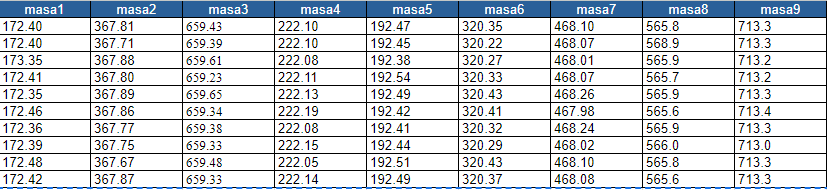

Datos tomados de las longitudes(medidas en cm):
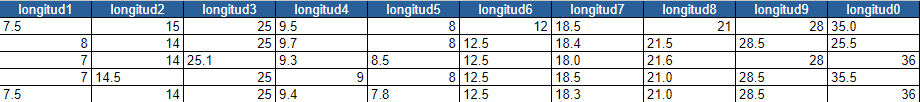

#### Cargamos los datos

In [577]:
#Experimentamos con 9 masas diferentes
datos = pd.read_excel('datos(Ley de Hooke).xlsx')

Calculamos Pesos

In [578]:
pesos_generales = []
masas_promedios = [] 
g = 981 #cm/s²

for i in range(1, 10):
    columna_masa = f'masa{i}'
    pasadas = []
    for j in range(0, 10):
        if datos[columna_masa][j] != 'NaN':
            pasadas.append(datos[columna_masa][j])
    masas_promedios.append(np.mean(pasadas))

for mp in masas_promedios:
    fuerza = mp * g
    pesos_generales.append(fuerza)

pesos_generales = np.array(pesos_generales)
masas_promedios = np.array(masas_promedios)

#Hago pasaje de gramos a kg
masas_promedios = masas_promedios / 1000

#Hago el pasaje a Newtons
pesos_generales = pesos_generales / 100000

Calculamos longitudes

In [579]:
longitudes_generales = []

for i in range(1, 10):
    columna_longitud = f'longitud{i}'
    pasadas = []
    for j in range(0, 5):
        if datos[columna_longitud][j] != 'NaN':
            pasadas.append(datos[columna_longitud][j])
    longitudes_generales.append(np.mean(pasadas))

longitudes_generales = np.array(longitudes_generales)

#Paso de cm a metros
longitudes_generales = longitudes_generales/100 

#### Plots para ver los gráficos

##### Calculamos los errores relativos

$\delta_{x}^{relativo}$ = $\frac{\sigma_x}{|x_{media}|}$

In [580]:
#Calculo el error relativo de la Fuerza Elastica
numerador_delta1 = np.std(pesos_generales)

#Calculo el error relativo de las longitudes


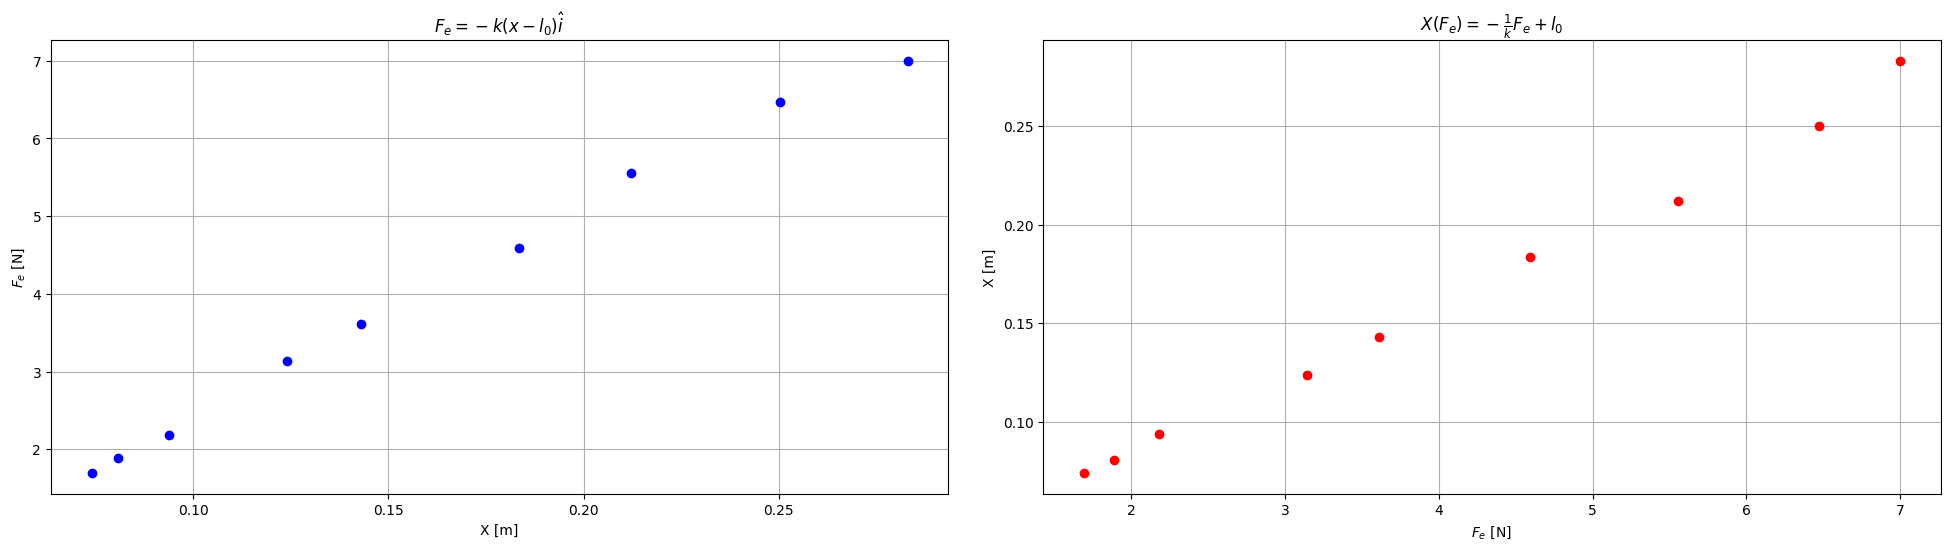

In [581]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].plot(longitudes_generales, pesos_generales, 'bo')
ax[0].set_title('$F_e=-k(x-l_0)\hat{i}$')
ax[0].set(ylabel=r'$F_e$ [N]', xlabel='X [m]')
ax[0].grid()

ax[1].plot(pesos_generales, longitudes_generales, 'ro')
ax[1].set_title(r'$X(F_e)=-\frac{1}{k}F_e+l_0$')
ax[1].set(xlabel=r'$F_e$ [N]', ylabel='X [m]')
ax[1].grid()

plt.tight_layout(pad=2.5)
plt.show()

#### Coeficiente de correlacion de Person

In [582]:
print(f'Como nuestro coeficiente de correlacion de Person es de: {coef_person(9, pesos_generales, longitudes_generales)} entonces los datos poseen una alta relacion entre ellos')

Como nuestro coeficiente de correlacion de Person es de: 0.9981335527305893 entonces los datos poseen una alta relacion entre ellos


#### Calculamos Cuadrados Mínimos

Calculamos K, $l_o$ con las siguientes ideas:

* $b$ = $l_0$<br><br>
* $A$ = $-\frac{1}{k}$ &nbsp;&nbsp; $\Longleftrightarrow$ &nbsp;&nbsp; $k$ = $\frac{1}{A}$


Calculamos sigmas del estiramiento:

In [583]:
#Para utilizar las funcionas a,b necesitamos todos los sigmas del eje y:
sigmas_longitudes = []

for i in range(1, 10):
    columna_longitud = f'longitud{i}'
    pasadas = []
    for j in range(0, 5):
        if datos[columna_longitud][j] != 'NaN':
            pasadas.append(datos[columna_longitud][j])
    sigmas_longitudes.append(np.std(pasadas))

sigmas_longitudes = np.array(sigmas_longitudes)

#sigmas masas

sigmas_masas = []

for i in range(1, 10):
    columna_masas = f'masa{i}'
    pasadas = []
    for j in range(0, 5):
        if datos[columna_masas][j] != 'NaN':
            pasadas.append(datos[columna_masas][j])
    sigmas_masas.append(np.std(pasadas))

sigmas_masas= np.array(sigmas_masas)

sigmas_masas_kg= sigmas_masas/1000


#Paso de cm a m
sigmas_longitudes = sigmas_longitudes/100

Calculamos la recta que mejor aproxima a nuestros datos, y al mismo tiempo conseguimos de ella $k$ y $l_0$ del resorte

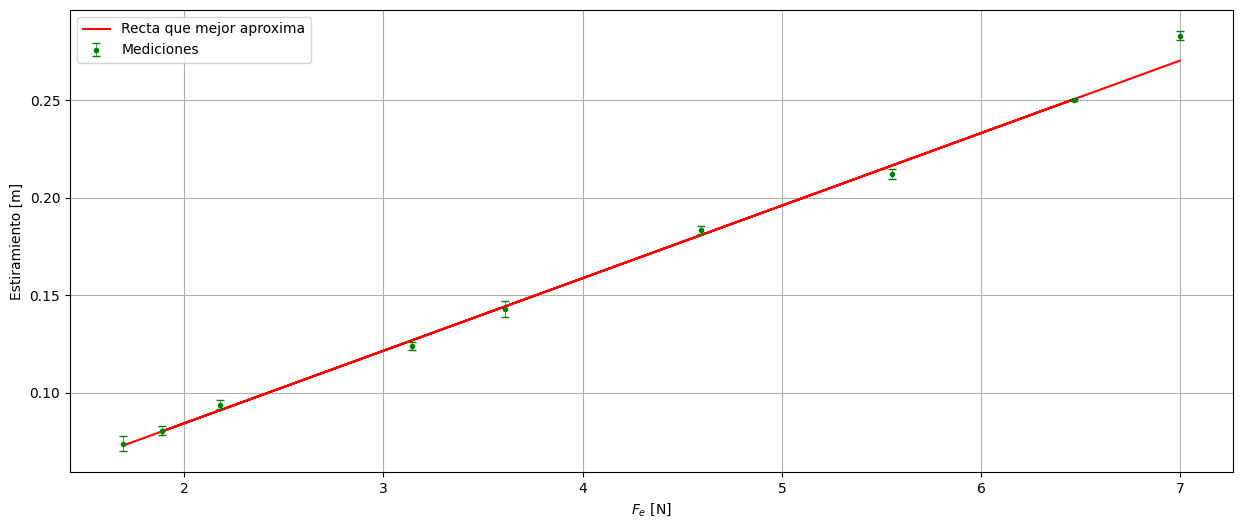

In [584]:
plt.figure(1, figsize=(15,6))
plt.plot(pesos_generales, f(pesos_generales, longitudes_generales, sigmas_longitudes), 'r-', label='Recta que mejor aproxima')
plt.errorbar(pesos_generales, longitudes_generales, yerr=sigmas_longitudes, fmt='.', color='green', elinewidth=0.5, capsize=3, label='Mediciones')

plt.title('')
plt.xlabel(r'$F_e$ [N]')
plt.ylabel('Estiramiento [m]')

plt.grid()
plt.legend()
plt.show()

#### Probabilidad de cada dato que tenemos ( $\chi^2$)

Como nuestra ecuacion es:  
$X(F_e)=-\frac{1}{k}F_e + l_0$<br><br>
Nuetros grados de libertad son:  
$df$ = 9 - 2 = 7&nbsp;&nbsp; $\Rightarrow$ &nbsp;&nbsp; $df$=7

In [585]:
print(p_value(longitudes_generales, f(pesos_generales, longitudes_generales, sigmas_longitudes), sigmas_longitudes, 9, 2))

6.2510345397329435e-06


Visualizando el plot anterior y viendo el resultado del $\chi^2$ decidimos desconfiar del último dato obtenido, ya que no confiamos en como fue medido

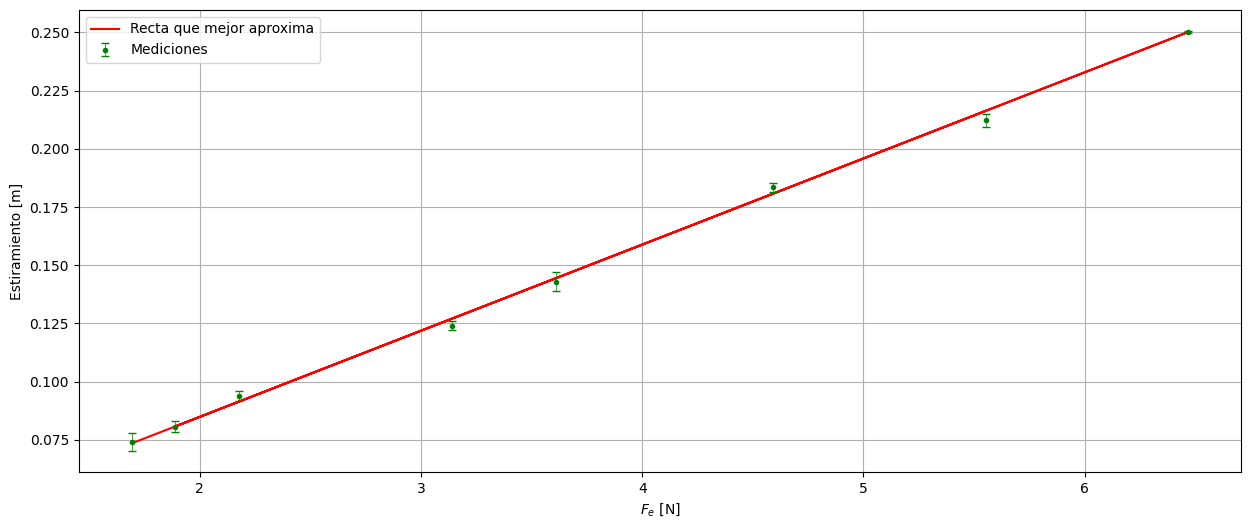

In [586]:
plt.figure(1, figsize=(15,6))
plt.plot(pesos_generales[:-1], f(pesos_generales[:-1], longitudes_generales[:-1], sigmas_longitudes[:-1]), 'r-', label='Recta que mejor aproxima')
plt.errorbar(pesos_generales[:-1], longitudes_generales[:-1], yerr=sigmas_longitudes[:-1], fmt='.', color='green', elinewidth=0.5, capsize=3, label='Mediciones')

plt.title('')
plt.xlabel(r'$F_e$ [N]')
plt.ylabel('Estiramiento [m]')

plt.grid()
plt.legend()
plt.show()

Volvemos a calcular $\chi^2$ sin contar el último dato

In [587]:
print(p_value(longitudes_generales[:-1], f(pesos_generales[:-1], longitudes_generales[:-1], sigmas_longitudes[:-1]), sigmas_longitudes[:-1], 8, 2))

0.24273214432401444


#### Obtenemos los valores de k y $l_0$

In [588]:
k = 1 / a(pesos_generales[:-1], longitudes_generales[:-1], sigmas_longitudes[:-1])
l_0 = b(pesos_generales[:-1], longitudes_generales[:-1], sigmas_longitudes[:-1])


print(f'||Nuestro valor de k = {k}|| , ||Nuestro valor de l0 = {l_0}||')

||Nuestro valor de k = 27.036161398993432|| , ||Nuestro valor de l0 = 0.010898399264025778||


#### Calculamos los errores de cada magnitud medida y obtenida

##### Masas:

Para cada masa realizamos 10 mediciones, entonces con ellos armamos una lista que contenga los sigmas/errores de cada medicion por separado.  
Es importante aclarar que los datos de las masas fueron tomados de forma directa a través de una balanza

In [589]:
sigmas_masas = []

for i in range(1, 10):
    columna_masa = f'masa{i}'
    pasadas = []
    for j in range(0, 10):
        if datos[columna_masa][j] != 'NaN':
            pasadas.append(datos[columna_masa][j])
    sigmas_masas.append(np.std(pasadas))

sigmas_masas = np.array(sigmas_masas[:-1])

##### Fuerza elástica:

Una vez obtenidos los sigmas de las masas ya podemos calcular el error de la fuerza elastica(peso), y los podemos obtener de la siguiente forma sabiendo que:  

$F_e = Peso = mg$  


$=>\sigma_{F_e} = \sqrt{(\frac{\partial F_e}{\partial m})²\sigma_m² + (\frac{\partial F_e}{\partial g})²\sigma_g²}$  

Debemos repetir esto para cada masa, ya que el error de la fuerza elastica varia para cada medicion

In [590]:
gravedad = 9.799165 #m/s²
error_gravedad = 0.008 #m/s²
m, g = sp.symbols('m g')
peso_fe = m * g

#Calculamos las derivadas
dp_dm = m
sigmas_fe = []
for i in range(0, 8):
    radicando = ((masas_promedios[i]/1000) **2) * ((sigmas_masas[i]/1000) ** 2) + (gravedad**2) * (error_gravedad**2)
    sigmas_fe.append(np.sqrt(radicando))

##### Constante Elástica $(k)$:

Considerando que la ecuacion:  

$K(A)=\frac{1}{A}$  ,siendo A la pendiente y su error fue calculado mas arriba

$\sigma_k=\sqrt{(\frac{\partial k}{\partial A})^2  \sigma_A²}$

In [591]:
#Calculo la derivada con respecto a A:
A = sp.symbols('A')
k = 1 / A
dk_dA = sp.lambdify(A, derivada_parcial(A, k))

#Calculo la incerteza de k:
radincando_k = (dk_dA(a(pesos_generales[:-1], longitudes_generales[:-1], sigmas_longitudes[:-1]))**2) * (sigma_a(pesos_generales[:-1], longitudes_generales[:-1], sigmas_longitudes[:-1])**2)
ek = np.sqrt(radincando_k)

##### Longitud Natural $(l_0)$

Nuesto $l_0$, como fue mencionado anteriormente, lo calculamos a través de Cuadrados Mínimos Ponderados, por como son las ecuaciones lo podemos conseguir como la pendiente de nuestra recta, ya que:  

$l_0$ = $b$  $\Longrightarrow$ $\sigma_(l_0)$ = $\sqrt{(\frac{\partial l_0}{\partial b})^2 \sigma_b^2}$  

Pero como: "$\frac{\partial l_0}{\partial b}$ = 1"  

$\sigma_(l_0)$ = $\sqrt{(\frac{\partial l_0}{\partial b})^2 \sigma_b^2}$&nbsp;&nbsp;&nbsp;&nbsp;$\Longleftrightarrow$&nbsp;&nbsp;&nbsp;&nbsp;$\sigma_(l_0)$ = $\sigma_b$


In [592]:
el_0 = sigma_b(pesos_generales[:-1], longitudes_generales[:-1], sigmas_longitudes[:-1])

## Resultados

1.&nbsp;&nbsp;$k$ = (27.0  $\pm$  0.2) $\frac{N}{m}$  <br><br>
2.&nbsp;&nbsp;$l_o$ = (0.011 $\pm$ 0.002) $m$  <br><br>


# Parte 2

## Desarrollo Experimental

En este caso, nuestro analisis es desde una perpectiva $dinamica$ donde nuestra masa se encuentra en movimiento, en particular efectuando un movimiento oscilatorio.<br><br>

$\underline{\text{Elementos utilizados:}}$
* Barra de laboratorio
* Gancho
* Resorte de constante elastica $k$ 
* Soporte para colocar masas
* Balanza
* Dual range Force (con una resolucion de 10N)
* Motion DAQ con una frecuencia de adquisicion de 200 <br>

$\underline{\text{Idea:}}$

Utilizamos el dual range force para calcular la fuerza elastica del restorte de forma dinamica y visualizamos los datos obtenidos de la fuerza E (N) en funcion del tiempo con Motion DAQ. La fuerza se comporta como una funcion sinoideal con un periodo, un omega y una amplitud correspondiente a esa funcion.

$\therefore$ $Fe(t)= Asen(w(x- x_0) + C$

Donde

$A$= La amplitud maxima que hace el resorte

$w= \sqrt \frac{k}{m + \frac{m_r}{3}}$ 

Como el resorte no es ideal, tuvimos que considerar la velocidad del resorte  relacionando su longitud y su energia cinetica. (Dudoso que sea por eso)

$C$= valor de la Fe en la posicion de equilibrio<br><br>
$\underline{\text{Objetivos:}}$

Conseguir a través de las mediciones:
* $w$: a partir de este dato obtenido de la funcion de la Fe, conseguimos el K y su error con curvefit
* $k$
* Verificar si se cumple la ley física

## Experimentacion

### Visualizando los datos

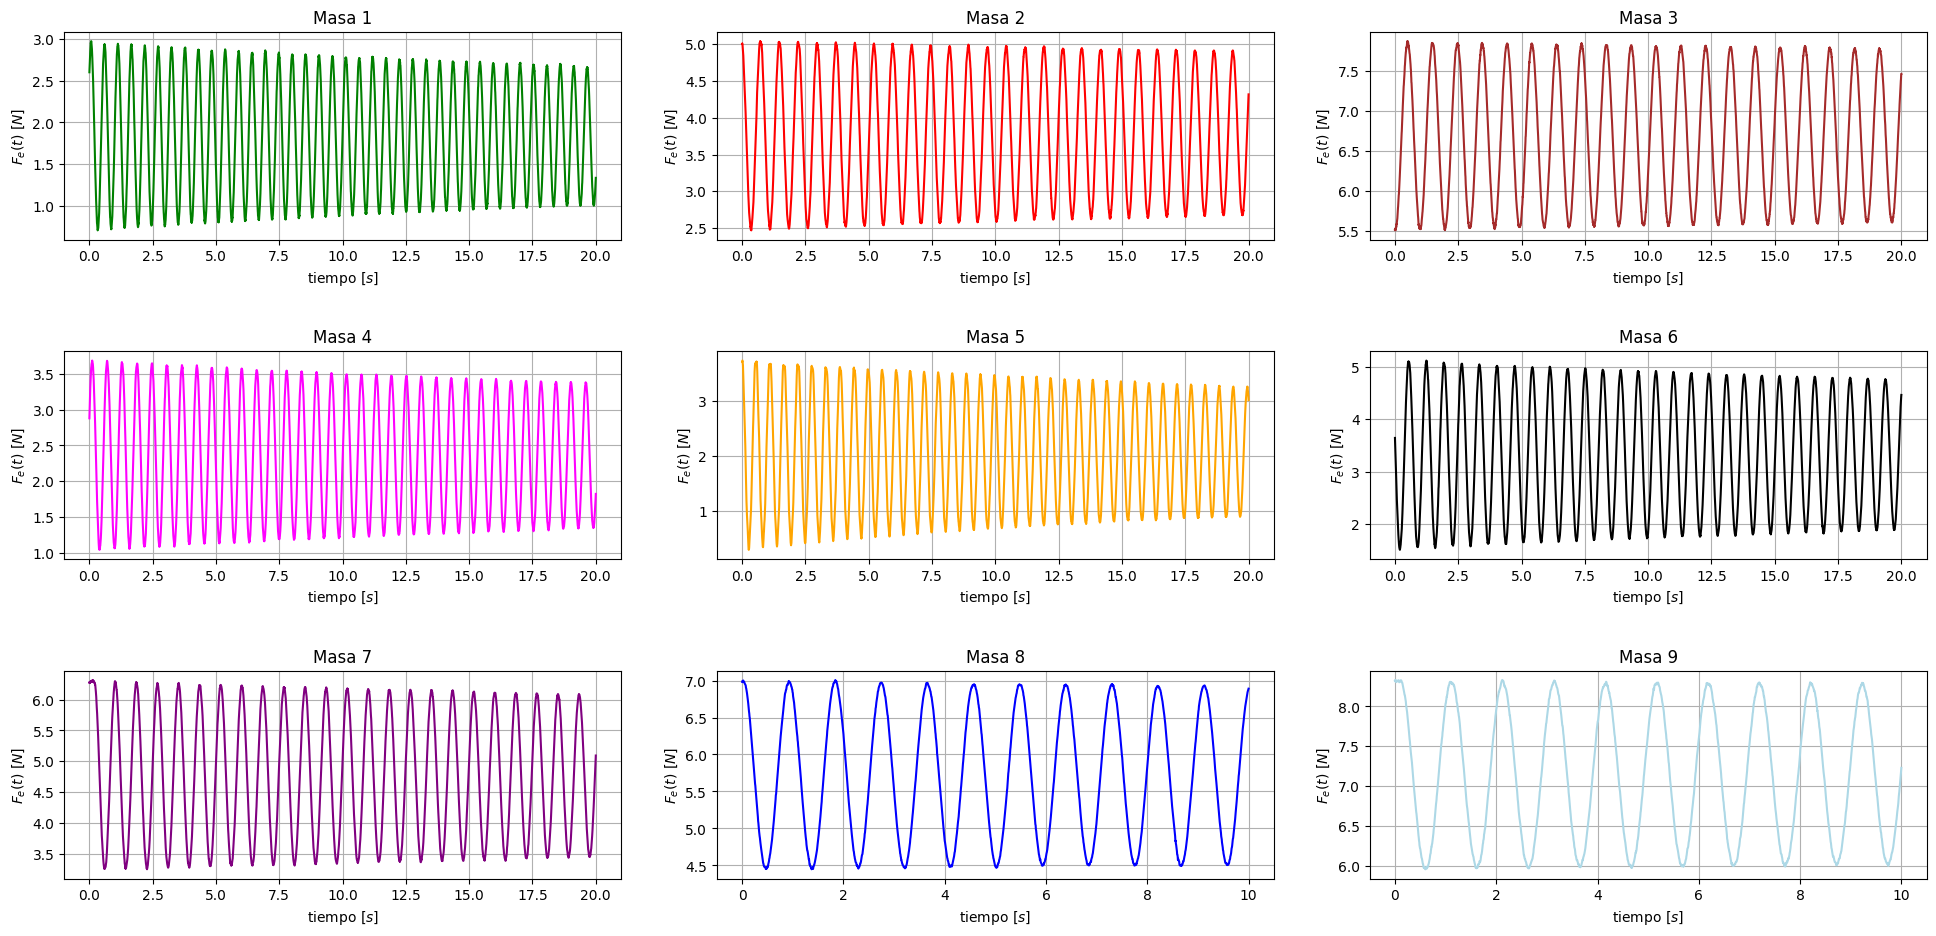

In [593]:
fig, ax = plt.subplots(3,3, figsize=(20,10))

#Experiencia 1 (Masa1)
newtons_ = np.array(fuerzas('m1')[1])
tiempos_ = np.array(fuerzas('m1')[0])
ax[0,0].plot(tiempos_, newtons_, color='green')
ax[0,0].set(title='Masa 1', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[0,0].grid()

#Experiencia 2 (Masa2)
newtons_ = np.array(fuerzas('m2')[1])
tiempos_ = np.array(fuerzas('m2')[0])
ax[0,1].plot(tiempos_, newtons_, color='red')
ax[0,1].set(title='Masa 2', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[0,1].grid()

#Experiencia 3 (Masa3)
newtons_ = np.array(fuerzas('m3')[1])
tiempos_ = np.array(fuerzas('m3')[0])
ax[0,2].plot(tiempos_, newtons_, color='brown')
ax[0,2].set(title='Masa 3', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[0,2].grid()

#Experiencia 4 (Masa4)
newtons_ = np.array(fuerzas('m4')[1])
tiempos_ = np.array(fuerzas('m4')[0])
ax[1,0].plot(tiempos_, newtons_, color='magenta')
ax[1,0].set(title='Masa 4', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[1,0].grid()

#Experiencia 5 (Masa5)
newtons_ = np.array(fuerzas('m5')[1])
tiempos_ = np.array(fuerzas('m5')[0])
ax[1,1].plot(tiempos_, newtons_, color='orange')
ax[1,1].set(title='Masa 5', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[1,1].grid()

#Experiencia 6 (Masa6)
newtons_ = np.array(fuerzas('m6')[1])
tiempos_ = np.array(fuerzas('m6')[0])
ax[1,2].plot(tiempos_, newtons_, color='black')
ax[1,2].set(title='Masa 6', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[1,2].grid()

#Experiencia 7 (Masa7)
newtons_ = np.array(fuerzas('m7')[1])
tiempos_ = np.array(fuerzas('m7')[0])
ax[2,0].plot(tiempos_, newtons_, color='purple')
ax[2,0].set(title='Masa 7', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[2,0].grid()

#Experiencia 8 (Masa8)
newtons_ = np.array(fuerzas('m8')[1])
tiempos_ = np.array(fuerzas('m8')[0])
ax[2,1].plot(tiempos_, newtons_, color='blue')
ax[2,1].set(title='Masa 8', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[2,1].grid()

#Experiencia 9 (Masa9)
newtons_ = np.array(fuerzas('m9')[1])
tiempos_ = np.array(fuerzas('m9')[0])
ax[2,2].plot(tiempos_, newtons_, color='lightblue')
ax[2,2].set(title='Masa 9', xlabel='tiempo [$s$]', ylabel=r'$F_e(t)$ [$N$]')
ax[2,2].grid()

plt.tight_layout(pad=3)
plt.show()

### Analizamos los datos a traves de los plots

Para poder usar curvefit y ajustar nuestros datos correctamente, decidimos tomar intervalos de tiempos en cada funcion  considerando el momento donde comenzaba a decaer la amplitud inicial, ya que se estaria considerando el rozamiento y los calculos no darian lo que buscamos.

Notar que le otorgamos condiciones iniciales de forma rudimentaria a curvefit para que tenga un dominio en el cual centrarse para encontrar un valor minimo y ajustar los datos de forma correcta. 

#### Masa 1


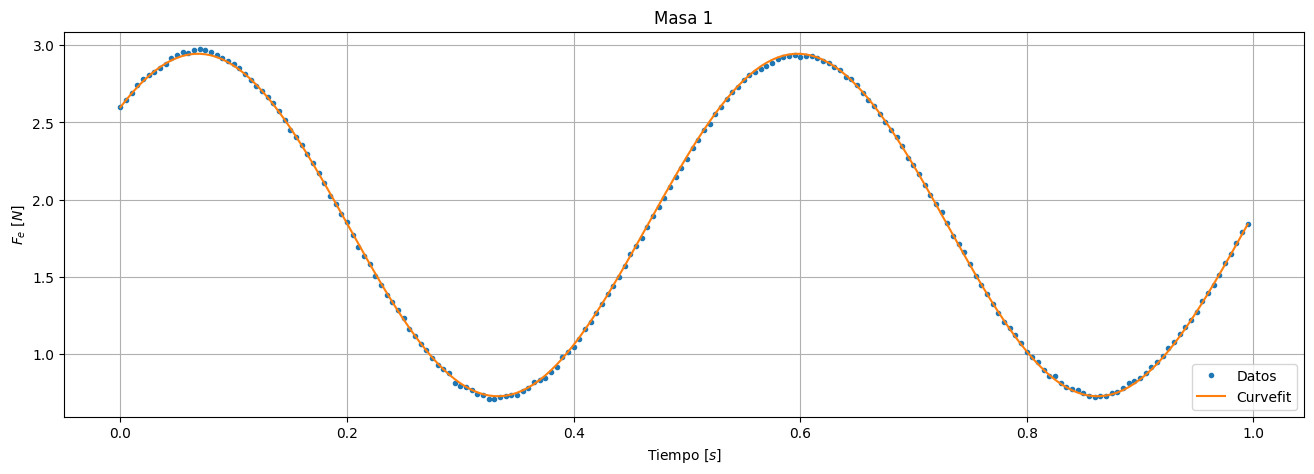

In [594]:
#Importamos los datos
newtons = fuerzas('m1')[1]
tiempo = fuerzas('m1')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 200
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_1  = 1.25
w_ajuste_1  = 2 * np.pi/0.5
x0_ajuste_1 = 0
c_ajuste_1 = 1.75
    
#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt1, pcov1 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_1, w_ajuste_1, x0_ajuste_1, c_ajuste_1])
pcov1 = np.sqrt(np.diag(pcov1))
ew1 = pcov1[1]
w1 = popt1[1]
A1 = popt1[0]
x01 = popt1[2]
c1 = popt1[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt1[0], popt1[1], popt1[2], popt1[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 1')

plt.legend(loc='lower right')
plt.grid()
plt.show()


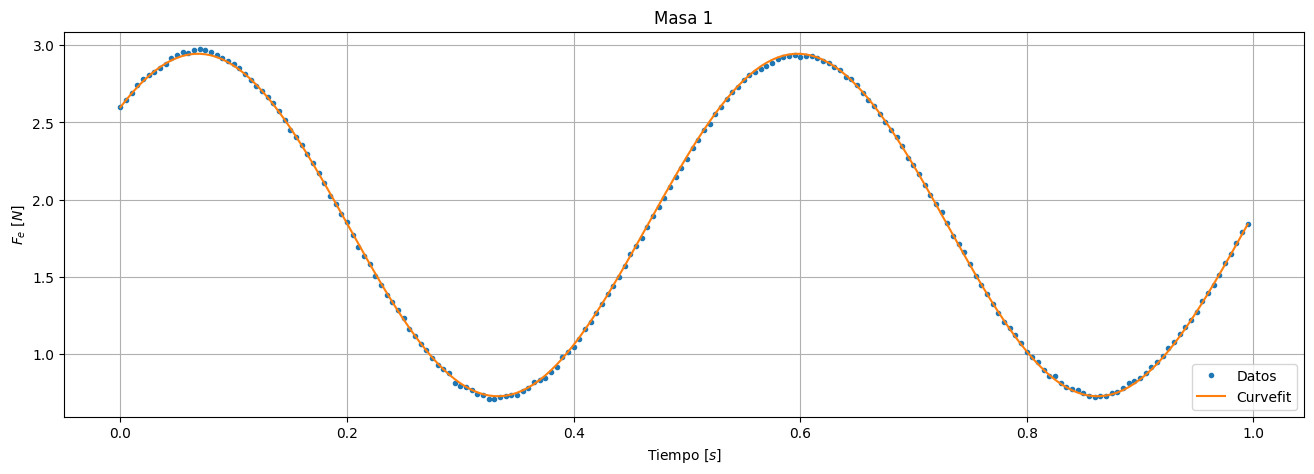

In [595]:
#Importamos los datos
newtons = fuerzas('m1')[1]
tiempo = fuerzas('m1')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 200
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_1  = 1.25
w_ajuste_1  = 2 * np.pi/0.5
x0_ajuste_1 = 0
c_ajuste_1 = 1.75
    
#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt1, pcov1 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_1, w_ajuste_1, x0_ajuste_1, c_ajuste_1])
pcov1 = np.sqrt(np.diag(pcov1))
ew1 = pcov1[1]
w1 = popt1[1]
A1 = popt1[0]
x01 = popt1[2]
c1 = popt1[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt1[0], popt1[1], popt1[2], popt1[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 1')

plt.legend(loc='lower right')
plt.grid()
plt.show()


#### Masa 2

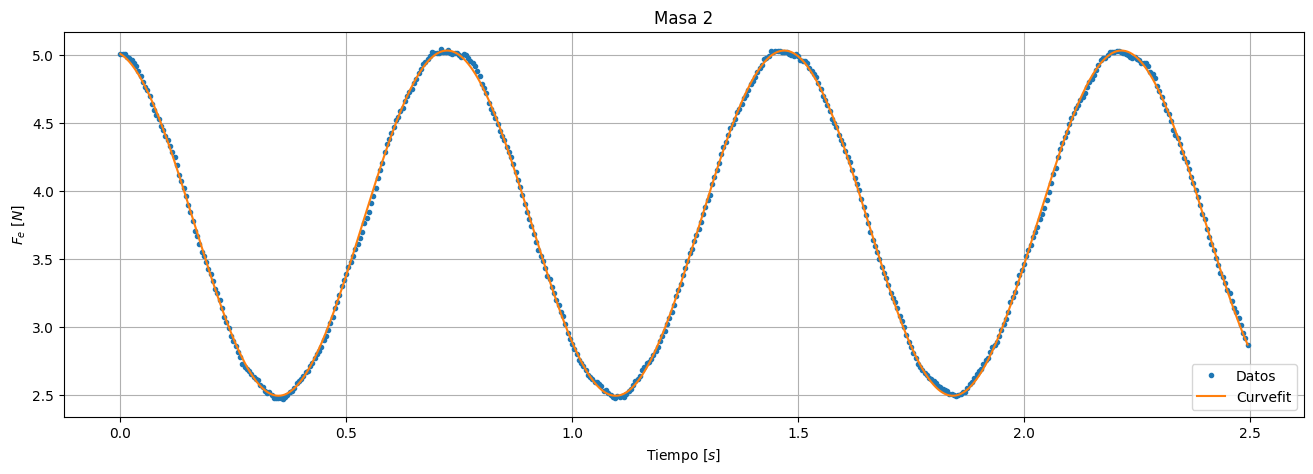

In [596]:
#Importamos los datos
newtons = fuerzas('m2')[1]
tiempo = fuerzas('m2')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 500
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_2  = 1.75
w_ajuste_2  = 2 * np.pi/0.9
x0_ajuste_2 = 0
c_ajuste_2 = 5.5

#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt2, pcov2 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_2, w_ajuste_2, x0_ajuste_2, c_ajuste_2])
pcov2 = np.sqrt(np.diag(pcov2))
ew2 = pcov2[1]
w2 = popt2[1]
A2 = popt2[0]
x02 = popt2[2]
c2 = popt2[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt2[0], popt2[1], popt2[2], popt2[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 2')

plt.legend(loc='lower right')
plt.grid()
plt.show()


#### Masa 3

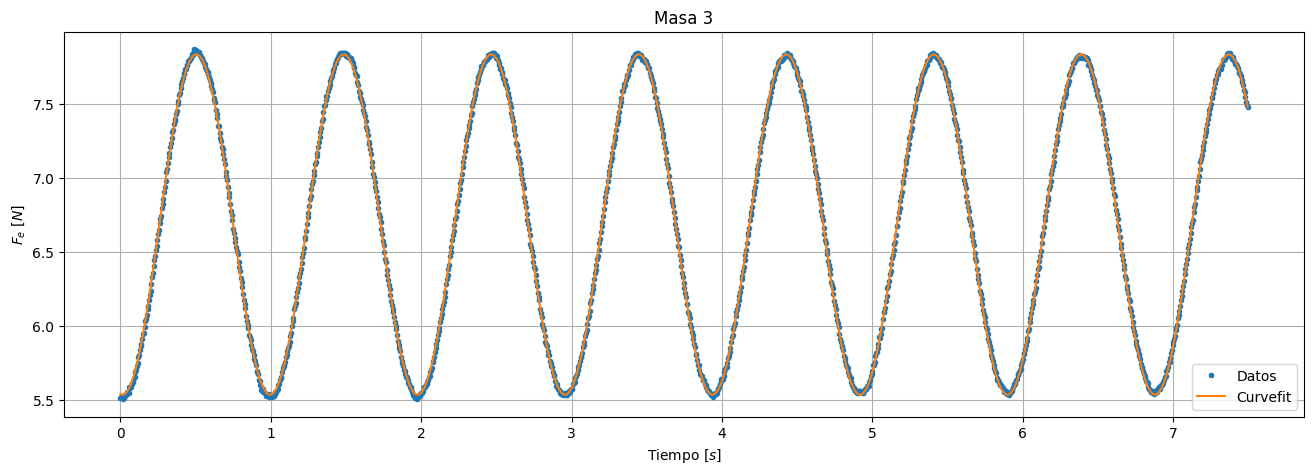

In [597]:
#Importamos los datos
newtons = fuerzas('m3')[1]
tiempo = fuerzas('m3')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 1500
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_3  = 1.25
w_ajuste_3  = 2 * np.pi
x0_ajuste_3 = 0
c_ajuste_3 = 6.75

#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt3, pcov3 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_3, w_ajuste_3, x0_ajuste_3, c_ajuste_3])
pcov3 = np.sqrt(np.diag(pcov3))
ew3 = pcov3[1]
w3 = popt3[1]
A3 = popt3[0]
x03 = popt3[2]
c3 = popt3[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt3[0], popt3[1], popt3[2], popt3[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 3')

plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Masa 4

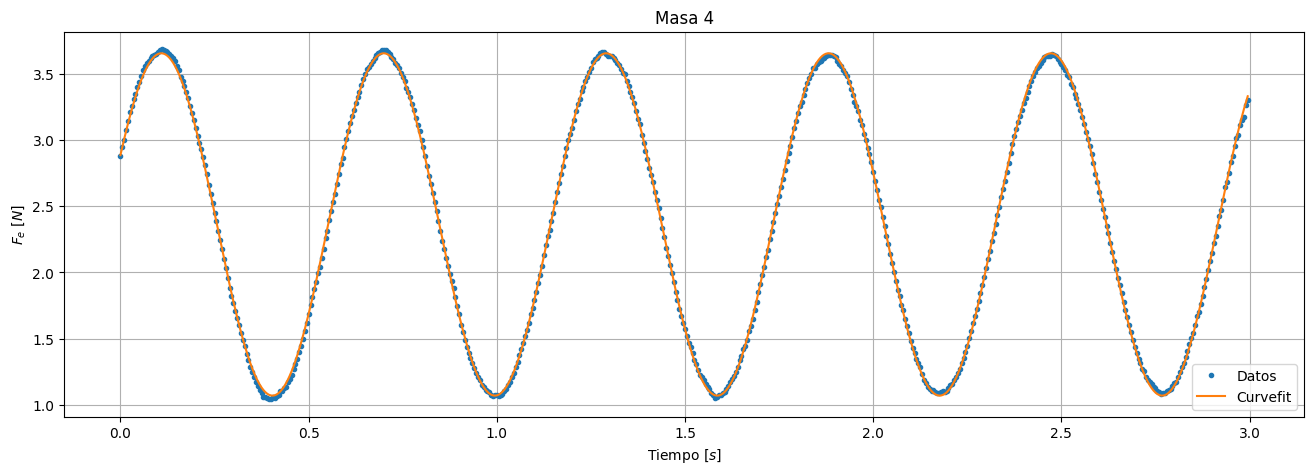

In [598]:
#Importamos los datos
newtons = fuerzas('m4')[1]
tiempo = fuerzas('m4')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 600
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_4  = 1.25
w_ajuste_4  = 2 * np.pi/0.6
x0_ajuste_4 = 0
c_ajuste_4 = 2.25

#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt4, pcov4 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_4, w_ajuste_4, x0_ajuste_4, c_ajuste_4])
pcov4 = np.sqrt(np.diag(pcov4))
ew4 = pcov4[1]
w4 = popt4[1]
A4 = popt4[0]
x04 = popt4[2]
c4 = popt4[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt4[0], popt4[1], popt4[2], popt4[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 4')

plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Masa 5

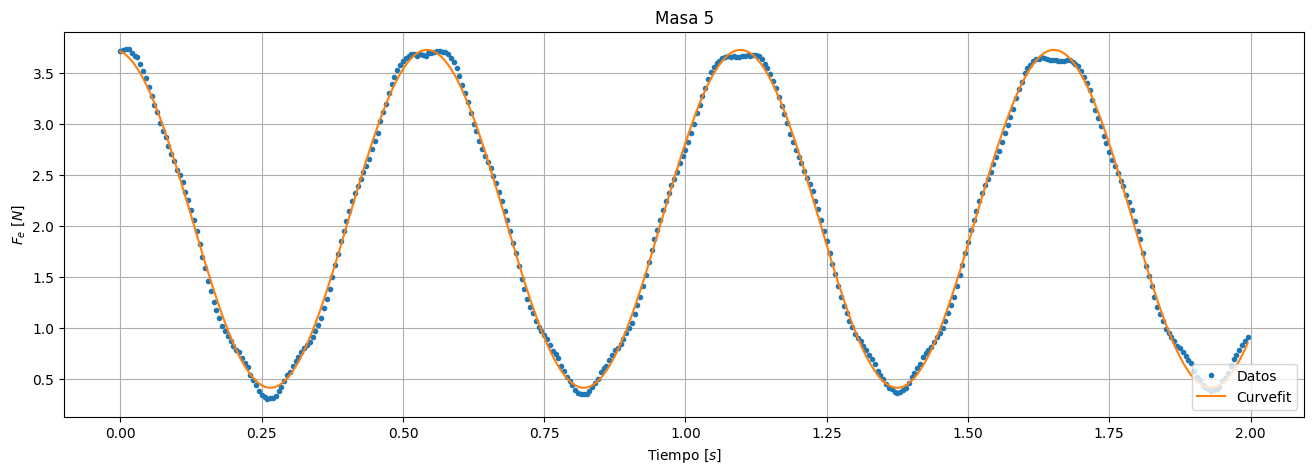

In [599]:
#Importamos los datos
newtons = fuerzas('m5')[1]
tiempo = fuerzas('m5')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 400
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_5  = 1.25
w_ajuste_5  = 2 * np.pi/0.6
x0_ajuste_5 = 0
c_ajuste_5 = 2.25

#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt5, pcov5 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_5, w_ajuste_5, x0_ajuste_5, c_ajuste_5])
pcov5 = np.sqrt(np.diag(pcov5))
ew5 = pcov5[1]
w5 = popt5[1]
A5 = popt5[0]
x05 = popt5[2]
c5 = popt5[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt5[0], popt5[1], popt5[2], popt5[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 5')

plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Masa 6

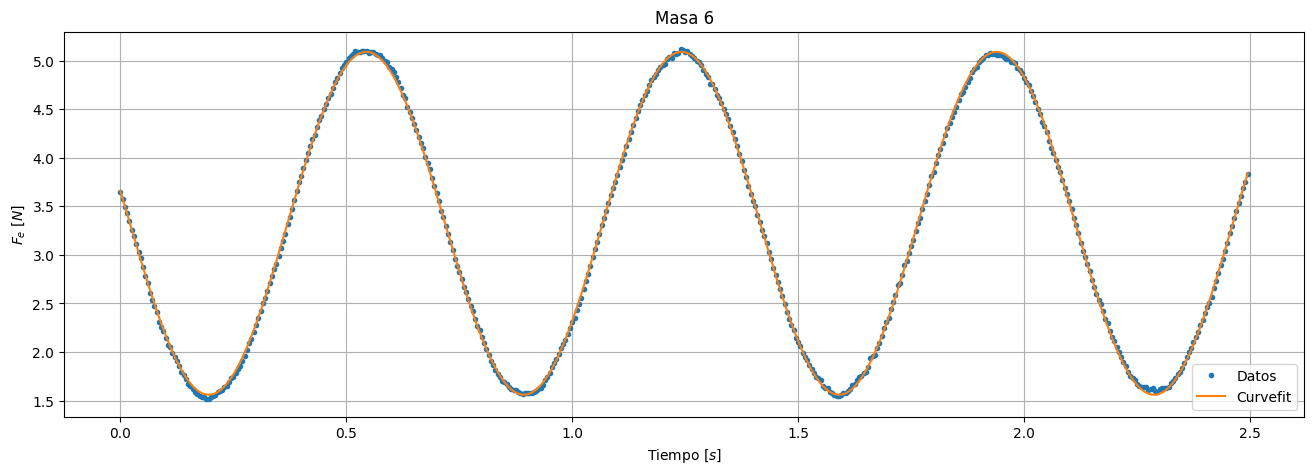

In [600]:
#Importamos los datos
newtons = fuerzas('m6')[1]
tiempo = fuerzas('m6')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 500
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_6  = 1.75
w_ajuste_6  = 2 * np.pi/0.6
x0_ajuste_6 = 0
c_ajuste_6 = 3.25

#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt6, pcov6 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_6, w_ajuste_6, x0_ajuste_6, c_ajuste_6])
pcov6 = np.sqrt(np.diag(pcov6))
ew6 = pcov6[1]
w6 = popt6[1]
A6 = popt6[0]
x06 = popt6[2]
c6 = popt6[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt6[0], popt6[1], popt6[2], popt6[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 6')

plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Masa 7

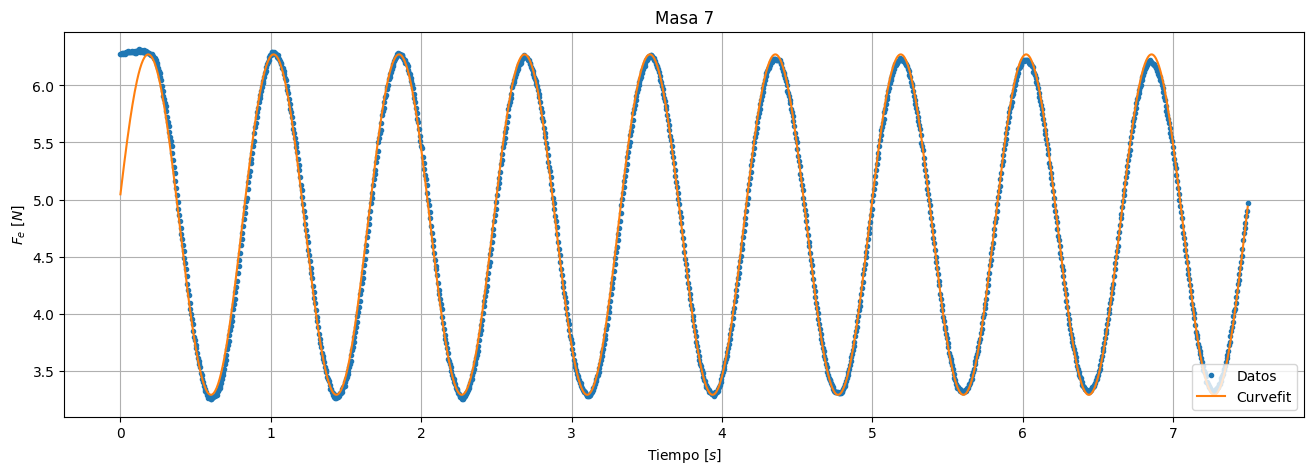

In [601]:
#Importamos los datos
newtons = fuerzas('m7')[1]
tiempo = fuerzas('m7')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 1500
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_7 = 4.75
w_ajuste_7  = 2 * np.pi/0.8
x0_ajuste_7 = 0
c_ajuste_7 = 1.75
    
#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt7, pcov7 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_7, w_ajuste_7, x0_ajuste_7, c_ajuste_7])
pcov7 = np.sqrt(np.diag(pcov7))
ew7 = pcov7[1]
w7 = popt7[1]
A7 = popt7[0]
x07 = popt7[2]
c7 = popt7[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt7[0], popt7[1], popt7[2], popt7[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 7')

plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Masa 8

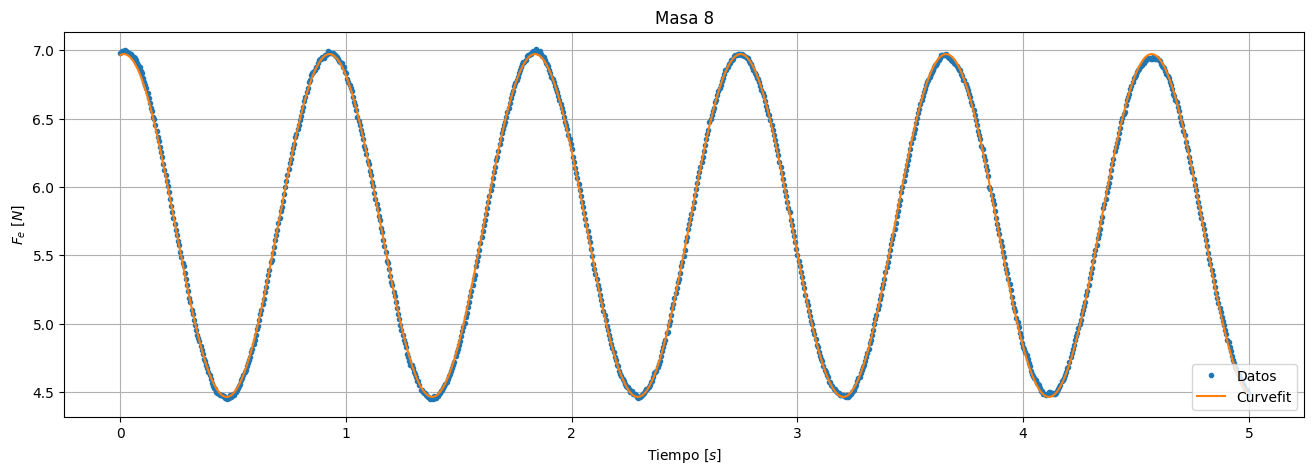

In [602]:
#Importamos los datos
newtons = fuerzas('m8')[1]
tiempo = fuerzas('m8')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 1000
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_8  = 5.75
w_ajuste_8  = 2 * np.pi/0.9
x0_ajuste_8 = 0
c_ajuste_8 = 1.25

#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt8, pcov8 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_8, w_ajuste_8, x0_ajuste_8, c_ajuste_8])
pcov8 = np.sqrt(np.diag(pcov8))
ew8 = pcov8[1]
w8 = popt8[1]
A8 = popt8[0]
x08 = popt8[2]
c8 = popt8[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt8[0], popt8[1], popt8[2], popt8[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 8')

plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Masa 9

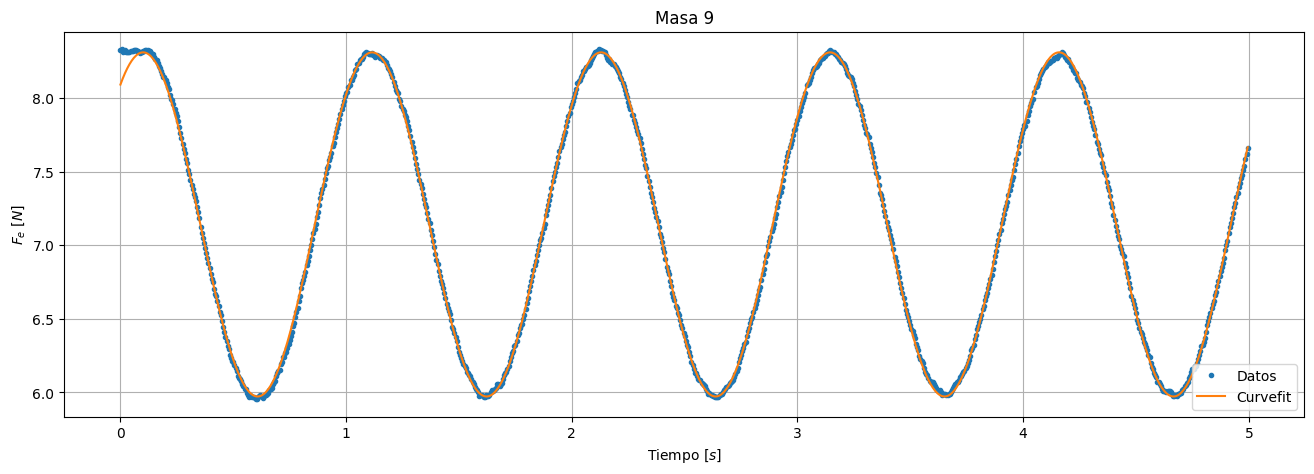

In [603]:
#Importamos los datos
newtons = fuerzas('m9')[1]
tiempo = fuerzas('m9')[0]

#Acortamos a los tiempos en los cuales no es notable el rozamiento con el aire
N = 1000
tiempo = tiempo[0:N]
newtons = newtons[0:N]

def fuerzaE(x,A,w,x0,c): return  A*np.sin(w * (x-x0)) + c

#Definimos los parametros para el ajuste
A_ajuste_9  = 2
w_ajuste_9  = 2 * np.pi
x0_ajuste_9 = 0
c_ajuste_9 = 7

#Utilizamos curvefit para hallar la curva que mejor adapte a nuestros resultados
popt9, pcov9 = curve_fit(fuerzaE, tiempo, newtons, p0=[A_ajuste_9, w_ajuste_9, x0_ajuste_9, c_ajuste_9])
pcov9 = np.sqrt(np.diag(pcov9))
ew9 = pcov9[1]
w9 = popt9[1]
A9 = popt9[0]
x09 = popt9[2]
c9 = popt9[3]

#Realizamos un plot sobre la masa
plt.figure(figsize=(16,5))
plt.plot(tiempo, newtons, '.', label='Datos')
plt.plot(tiempo, fuerzaE(tiempo, popt9[0], popt9[1], popt9[2], popt9[3]), label='Curvefit')

plt.ylabel(r'$F_e$ [$N$]')
plt.xlabel(r'Tiempo [$s$]')
plt.title('Masa 9')

plt.legend(loc='lower right')
plt.grid()
plt.show()

### Comparamos $\omega$ con la masa $(\omega(m))$:

Usamos la siguiente relacion:  


$\omega ^ 2$ = $\frac{k}{m + \frac{m_r}{3}}$<br><br>
Con esta relacion también podemos conseguir $k$<br><br>

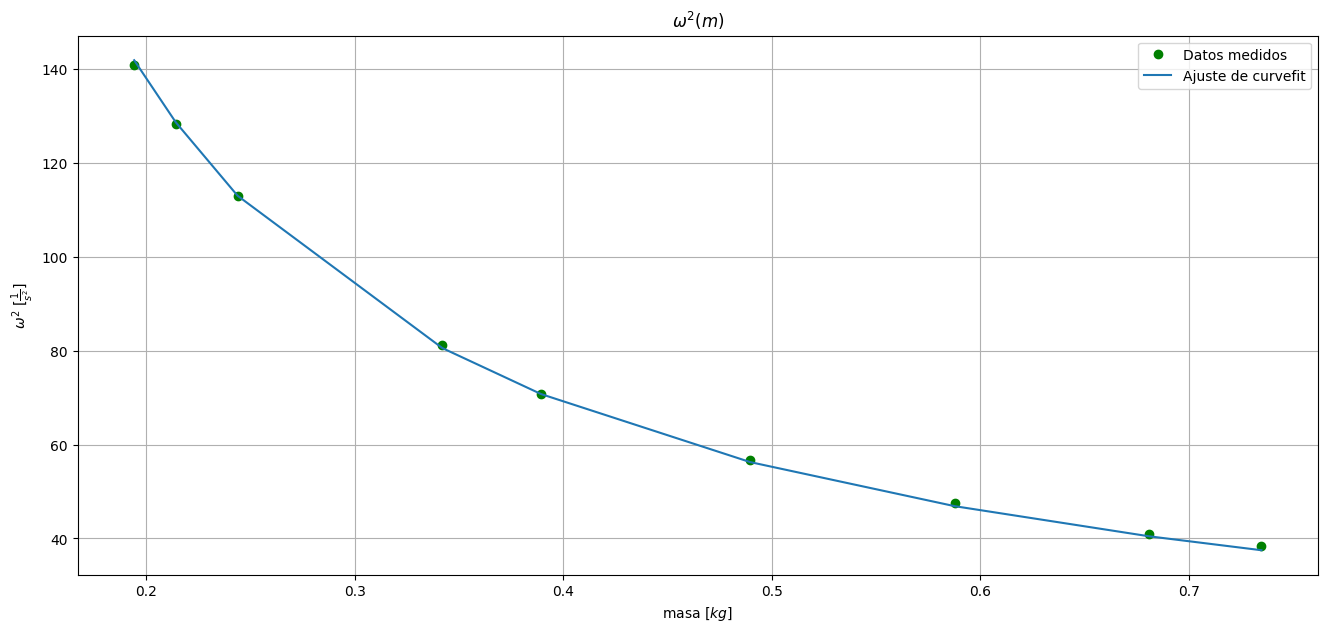

In [604]:
#Definimos w cuadrado
def w_cuadrado(m_tot, k): return (k / m_tot)

Omegas= np.array([w1,w2,w3,w4,w5,w6,w7,w8,w9])
masa_resor= 65.05/1000
masas_promedios_resorte = masas_promedios + (masa_resor / 3)

#Utilizamos curvefit:
poptk, pcovk = curve_fit(w_cuadrado, masas_promedios_resorte, Omegas**2)

#Plot de w(m):
plt.figure(figsize=(16, 7))
plt.plot(masas_promedios_resorte, Omegas**2,'go', label='Datos medidos')
plt.plot(np.array(sorted(masas_promedios_resorte)), np.array(sorted(w_cuadrado(masas_promedios_resorte, poptk[0]), reverse=True)), label='Ajuste de curvefit')

plt.xlabel(r'masa $[kg]$')
plt.ylabel(r'$\omega^2$ [$\frac{1}{s^2}$]')
plt.title(r'$\omega^2(m)$')

plt.legend()
plt.grid()
plt.show()

In [605]:
print(f'K es = {K_p2}')

K es = 27.55


### Error de K

A través de curvefit podemos obtener todos los errores

In [606]:
sigma_k= np.sqrt(np.diag(pcovk))

### Coeficiente de Pearson

In [607]:
coef_person(9, Omegas**2, masas_promedios_resorte)

0.944508706158323

Error de $\omega^2$

In [608]:
ew2 = np.sqrt((-poptk[0]/(np.mean(masas_promedios_p3) + masa_resor)**2)**2 * np.std(masas_promedios_p3)**2)

#### Probabilidad de cada dato que tenemos ( $\chi^2$)

Como nuestra ecuacion es:  
$\omega ^ 2$ = $\frac{k}{m + \frac{m_r}{3}}$  

Nuetros grados de libertad son:  
$df$ = 9 - 1 = 8&nbsp;&nbsp; $\Rightarrow$ &nbsp;&nbsp; $df$=8

In [609]:
print(p_value(Omegas**2, w_cuadrado(masas_promedios_resorte, poptk[0]), ew2, 9, 1))

0.9999999999949469


## Resultados

$K= (27.55 ± 0.07) \frac{N}{m}$


$p-value = 0.9999$

# Parte 3

## Desarrollo Experimental

La experiencia consiste en poner a oscilar un resorte con una masa sumergida en un medio viscoso, la cual era agua dentro de un recipiente, con esto buscabamos estudiar si se cumplia la ley física de un **Oscilador Armónico Subamortiguado** 

A través del diagrama de cuerpo libre llegamos a la siguiente ecuación:  
$\ddot{x}$ + $\frac{b}{m} \dot{x}$ + $\frac{k}{m}$ x = 0 **$_{(1)}$** <br><br>
Con esta ecuacion vamos a definir:  
* $\gamma$ = $\frac{b}{m}$ $:=$ Constante de amortiguamiento  
* $\omega$ = $\sqrt{\frac{k}{m}}$ $:=$ Frecuencia natural  <br>

Utilizando el SensorDAQ, podemos obtener una funcion de la oscilacion del resorte de la siguiente forma:<br><br>
$F(t)$ = $-kx(t) + Mg$ **$_{(2)}$** <br><br>
$\underline{\text{Objetivos:}}$  
* Obtener $k$
* Obtener $b$

## Experimentacion

Datos tomados de las masas(medidas en gramos):<br>
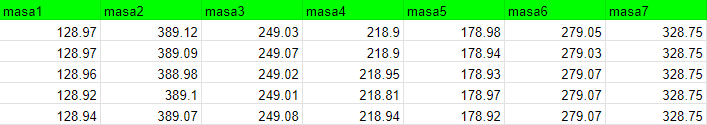

Para poder obtener los valores de $k$ y $b$: <br>
$F(t)=F_Ae^{-\gamma t}sin(\omega' t + \phi)_{(3)}$,&nbsp;&nbsp;/&nbsp;&nbsp;$\omega' = \sqrt{\omega_0^2 - \frac{\gamma^2}{4}} _{(4)}$

### Importamos las masas

In [610]:
#Cargamos los datos del excel
datos = pd.read_excel('segundas mediciones.xlsx')

#Guardamos los datos
masas_promedios_p3 = []
for i in range(1, 8):
    columna_masap3 = f'masa{i}'
    pasadas2 = []
    for j in range(0, 5):
        if datos[columna_masap3][j] != 'NaN':
            pasadas2.append(datos[columna_masap3][j])
    masas_promedios_p3.append(np.mean(pasadas2))
masas_promedios_p3 = np.array(masas_promedios_p3) / 1000

### Visualizacion de los datos

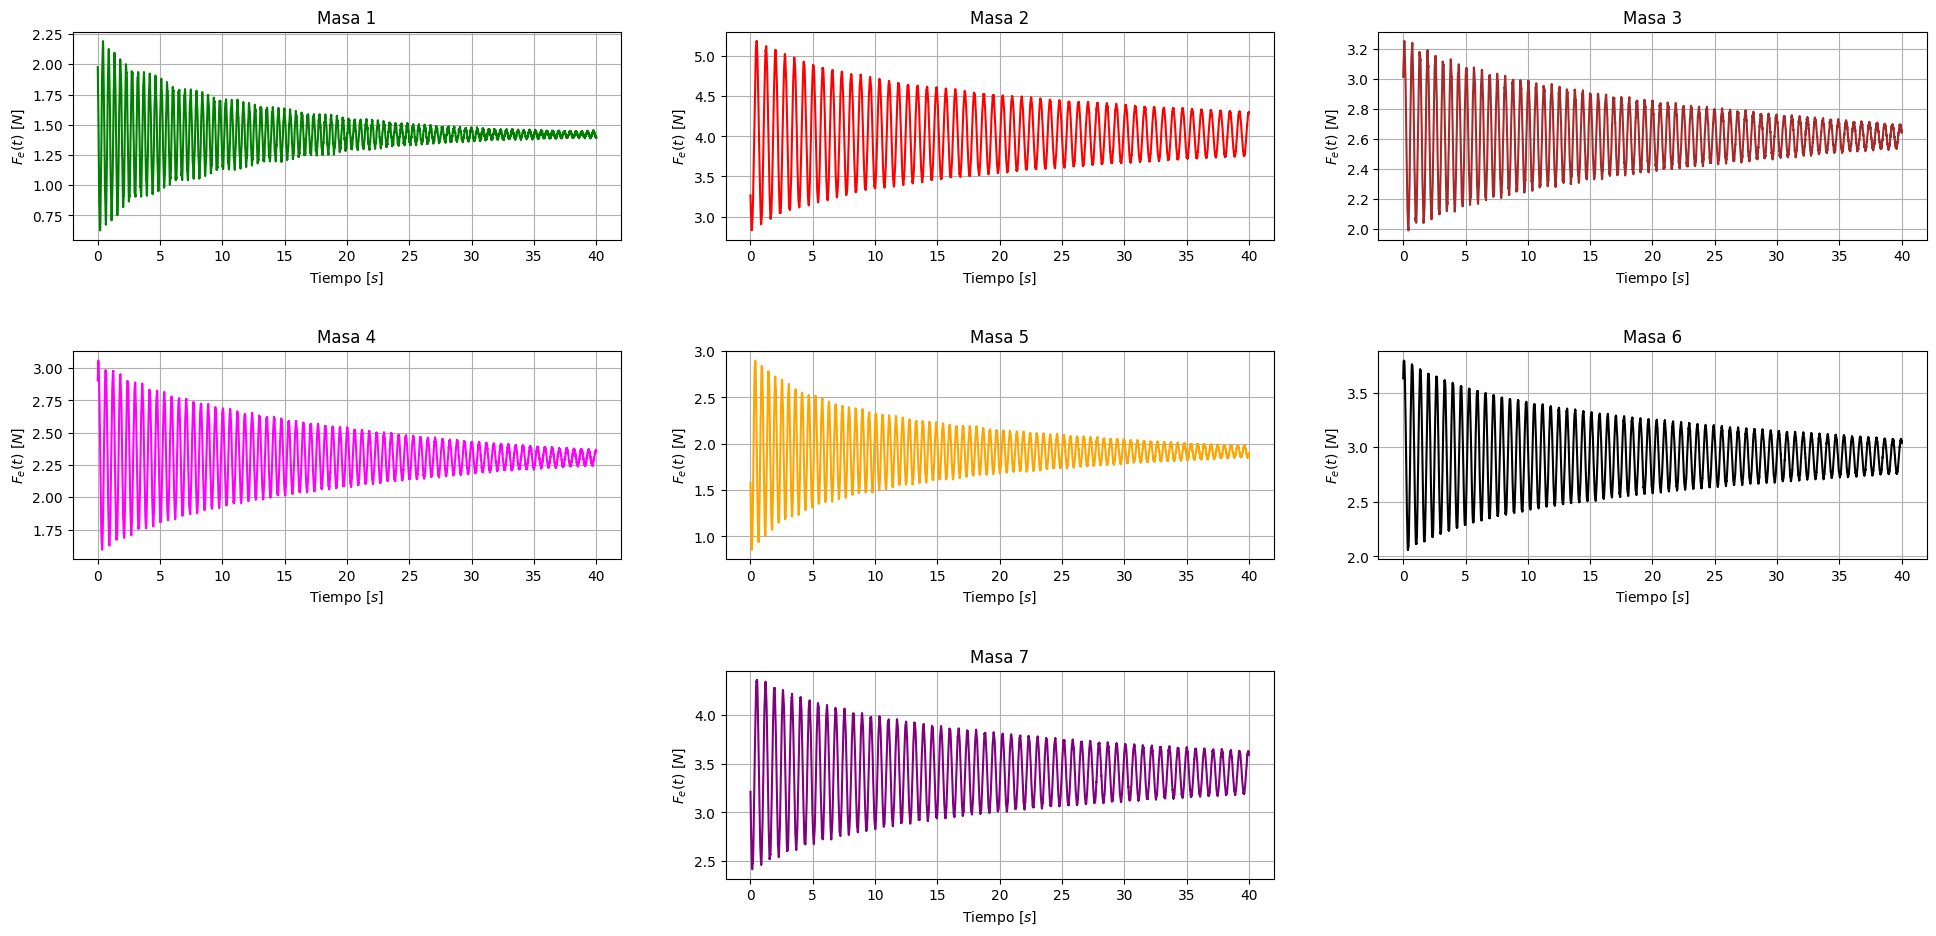

In [611]:
#fig, ax = plt.subplots(3,3, figsize=(20,10))
fig = plt.figure(figsize=(20,10))
spec = fig.add_gridspec(3,3)

#Experiencia 1 (Masa1)
newtons_ = np.array(fuerzas('p3m1')[1])
tiempos_ = np.array(fuerzas('p3m1')[0])
ax[0,0] = fig.add_subplot(spec[0,0])
ax[0,0].plot(tiempos_, newtons_, color='green')
ax[0,0].set(title='Masa 1', xlabel=r'Tiempo $[s]$', ylabel=r'$F_e(t)$ $[N]$')
ax[0,0].grid()

#Experiencia 2 (Masa2)
newtons_ = np.array(fuerzas('p3m2')[1])
tiempos_ = np.array(fuerzas('p3m2')[0])
ax[0,1] = fig.add_subplot(spec[0,1])
ax[0,1].plot(tiempos_, newtons_, color='red')
ax[0,1].set(title='Masa 2', xlabel=r'Tiempo $[s]$', ylabel=r'$F_e(t)$ $[N]$')
ax[0,1].grid()

#Experiencia 3 (Masa3)
newtons_ = np.array(fuerzas('p3m3')[1])
tiempos_ = np.array(fuerzas('p3m3')[0])
ax[0,2] = fig.add_subplot(spec[0,2])
ax[0,2].plot(tiempos_, newtons_, color='brown')
ax[0,2].set(title='Masa 3', xlabel=r'Tiempo $[s]$', ylabel=r'$F_e(t)$ $[N]$')
ax[0,2].grid()

#Experiencia 4 (Masa4)
newtons_ = np.array(fuerzas('p3m4')[1])
tiempos_ = np.array(fuerzas('p3m4')[0])
ax[1,0] = fig.add_subplot(spec[1,0])
ax[1,0].plot(tiempos_, newtons_, color='magenta')
ax[1,0].set(title='Masa 4', xlabel=r'Tiempo $[s]$', ylabel=r'$F_e(t)$ $[N]$')
ax[1,0].grid()

#Experiencia 5 (Masa5)
newtons_ = np.array(fuerzas('p3m5')[1])
tiempos_ = np.array(fuerzas('p3m5')[0])
ax[1,1] = fig.add_subplot(spec[1,1])
ax[1,1].plot(tiempos_, newtons_, color='orange')
ax[1,1].set(title='Masa 5', xlabel=r'Tiempo $[s]$', ylabel=r'$F_e(t)$ $[N]$')
ax[1,1].grid()

#Experiencia 6 (Masa6)
newtons_ = np.array(fuerzas('p3m6')[1])
tiempos_ = np.array(fuerzas('p3m6')[0])
ax[1,2] = fig.add_subplot(spec[1,2])
ax[1,2].plot(tiempos_, newtons_, color='black')
ax[1,2].set(title='Masa 6', xlabel=r'Tiempo $[s]$', ylabel=r'$F_e(t)$ $[N]$')
ax[1,2].grid()

#Experiencia 7 (Masa7)
newtons_ = np.array(fuerzas('p3m7')[1])
tiempos_ = np.array(fuerzas('p3m7')[0])
ax[2,0] = fig.add_subplot(spec[2,1])
ax[2,0].plot(tiempos_, newtons_, color='purple')
ax[2,0].set(title='Masa 7', xlabel=r'Tiempo $[s]$', ylabel=r'$F_e(t)$ $[N]$')
ax[2,0].grid()

plt.tight_layout(pad=3)
plt.show()

### Analizamos los datos a través de los plots

#### Definimos Conidiciones Iniciales generales

##### Oscilador amortiguado

Definimos la ecuación $_{(2)}$ en una función de python

In [612]:
#Funcion posicion
def FAmort(t,Fa,Fo,gamma,W,phi): 
    return Fa*(np.exp(-gamma*t))*np.sin(W*t+phi)+Fo 

##### Valore de k

In [613]:
#Definimos k con el valor obtenido con la experimentacion 1
k_p3 = 26.898561089027016

#### Visualizamos el plot de cada masa

Realizamos los ajustes necesarios para darle a Curvefit

##### Masa 1

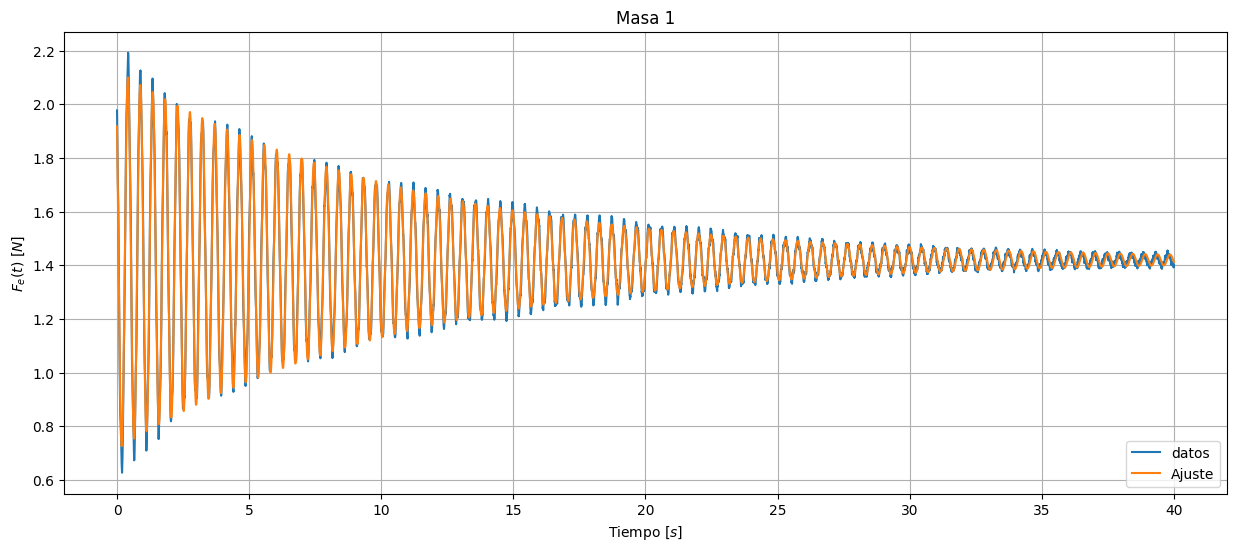

In [614]:
#Importamos los datos
newtons_ = np.array(fuerzas('p3m1')[1])
tiempos_ = np.array(fuerzas('p3m1')[0])

#Condiciones iniciales
Fa = 0.8
Fo = masas_promedios_p3[0] + masa_resor
gamma = 0.3
w = 0.7
phi = np.pi/2

#Utilizamos Curvefit
popt, pcov = curve_fit(FAmort, tiempos_, newtons_, p0=[Fa, Fo, gamma, w, phi])

#Obtengo las incertesas
pcov = np.sqrt(np.diag(pcov))

#Guardamos los datos de curvefit junto con sus errores:
gamma_1 = popt[2]
egamma_1 = pcov[2]
wp_1 = popt[3]
ewp_1 = pcov[3]

#Realizamos un plot
plt.figure(figsize=(15,6))
plt.plot(tiempos_,newtons_, label='datos')
plt.plot(tiempos_, FAmort(tiempos_, popt[0], popt[1], popt[2], popt[3], popt[4]), label='Ajuste')

plt.title('Masa 1')
plt.ylabel(r'$F_e(t)$ $[N]$')
plt.xlabel(r'Tiempo $[s]$')

plt.legend(loc='lower right')
plt.grid()
plt.show()

In [615]:
(masas_promedios_p3[0] + masa_resor)*(gamma_1**2/4 + wp_1**2)

34.73414985496286

##### Masa 2

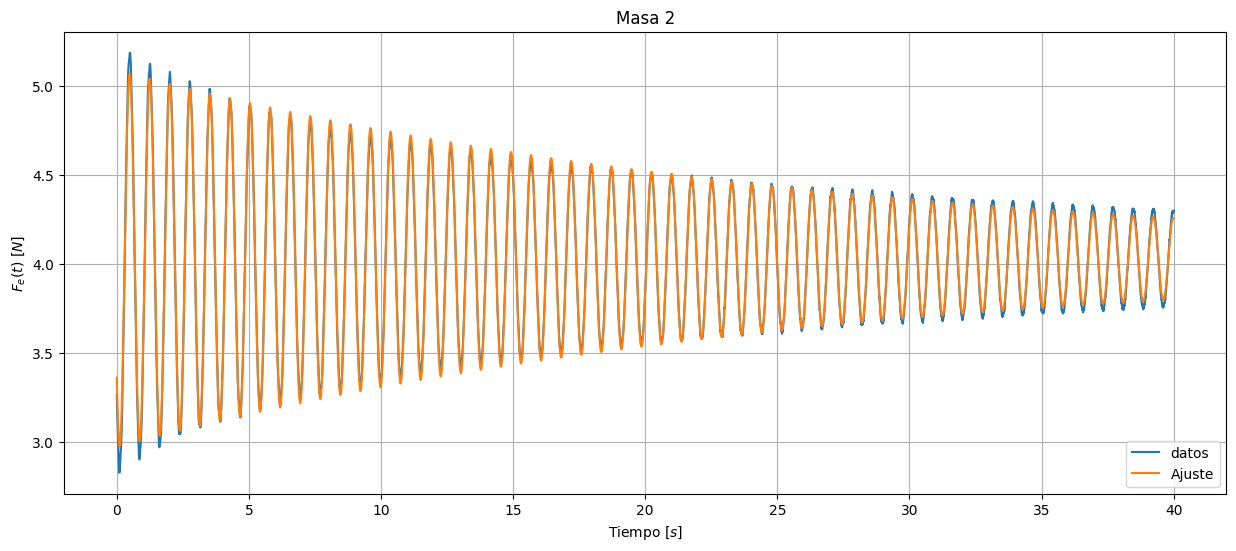

In [616]:
#Importamos los datos
newtons_ = np.array(fuerzas('p3m2')[1])
tiempos_ = np.array(fuerzas('p3m2')[0])

#Condiciones iniciales
Fa = 1
Fo = masas_promedios_p3[1] + masa_resor
gamma = 0.3
w = 0.7
phi = 3*np.pi/2

#Utilizamos Curvefit
popt, pcov = curve_fit(FAmort, tiempos_, newtons_, p0=[Fa, Fo, gamma, w, phi])

#Obtengo las incertesas
pcov = np.sqrt(np.diag(pcov))

#Guardamos los datos de curvefit junto con sus errores:
gamma_2 = popt[2]
egamma_2 = pcov[2]
wp_2 = popt[3]
ewp_2 = pcov[3]

#Realizamos un plot
plt.figure(figsize=(15,6))
plt.plot(tiempos_,newtons_, label='datos')
plt.plot(tiempos_, FAmort(tiempos_, popt[0], popt[1], popt[2], popt[3], popt[4]), label='Ajuste')

plt.title('Masa 2')
plt.ylabel(r'$F_e(t)$ $[N]$')
plt.xlabel(r'Tiempo $[s]$')

plt.legend(loc='lower right')
plt.grid()
plt.show()


##### Masa 3

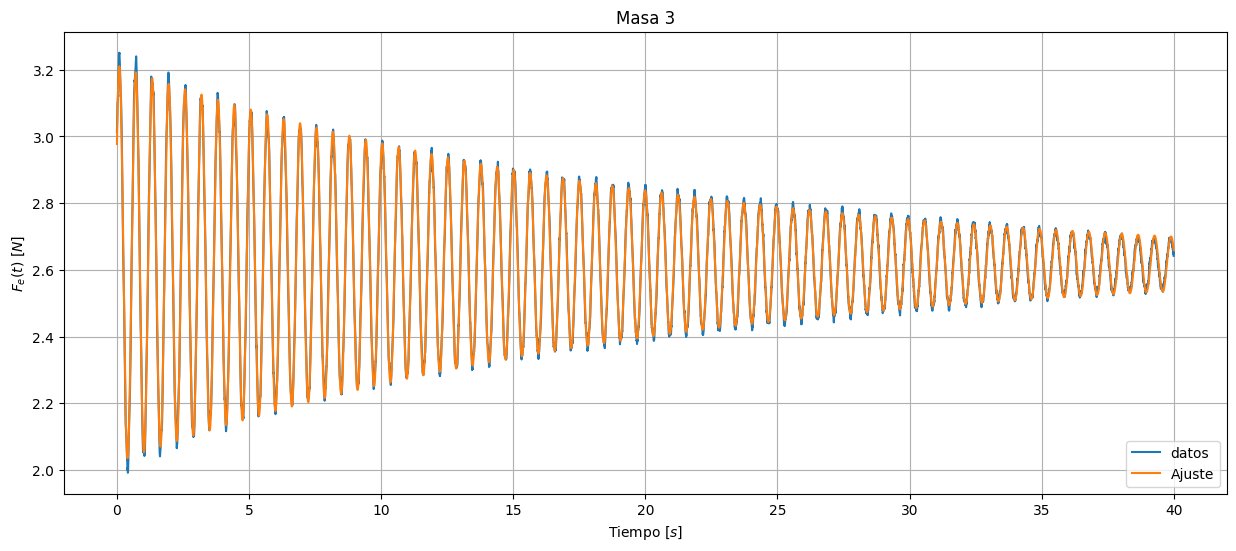

In [617]:
#Importamos los datos
newtons_ = np.array(fuerzas('p3m3')[1])
tiempos_ = np.array(fuerzas('p3m3')[0])

#Condiciones iniciales
Fa = 0.6
Fo = masas_promedios_p3[2] + masa_resor
gamma = 0.3
w = 0.7
phi = np.pi/2

#Utilizamos Curvefit
popt, pcov = curve_fit(FAmort, tiempos_, newtons_, p0=[Fa, Fo, gamma, w, phi])

#Obtengo las incertesas
pcov = np.sqrt(np.diag(pcov))

#Guardamos los datos de curvefit junto con sus errores:
gamma_3 = popt[2]
egamma_3 = pcov[2]
wp_3 = popt[3]
ewp_3 = pcov[3]

#Realizamos un plot
plt.figure(figsize=(15,6))
plt.plot(tiempos_,newtons_, label='datos')
plt.plot(tiempos_, FAmort(tiempos_, popt[0], popt[1], popt[2], popt[3], popt[4]), label='Ajuste')

plt.title('Masa 3')
plt.ylabel(r'$F_e(t)$ $[N]$')
plt.xlabel(r'Tiempo $[s]$')

plt.legend(loc='lower right')
plt.grid()
plt.show()

##### Masa 4

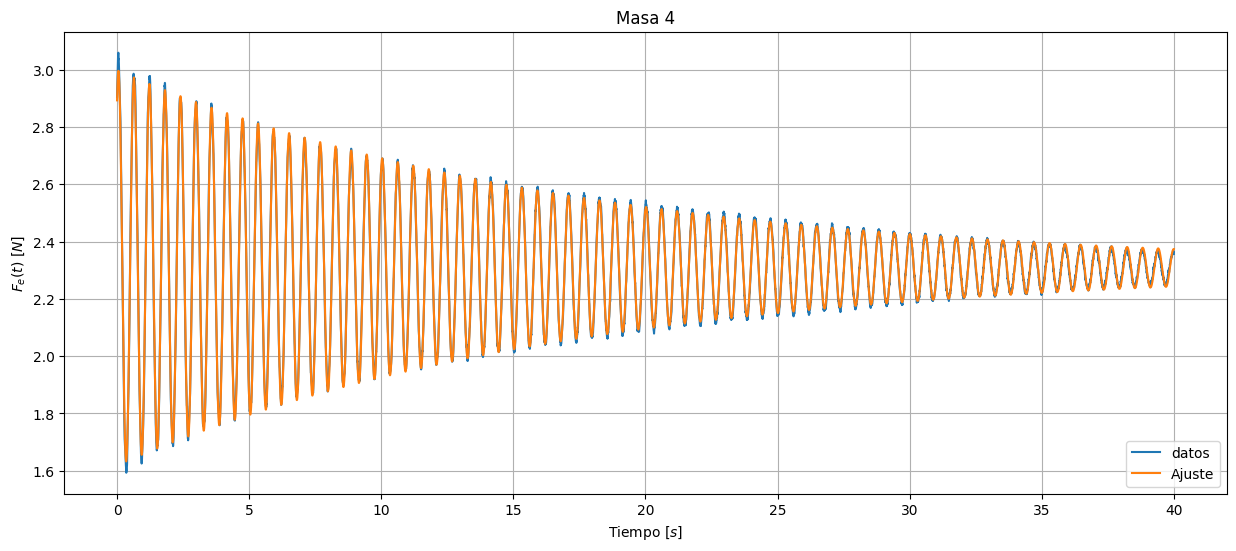

In [618]:
#IMportamos los datos
newtons_ = np.array(fuerzas('p3m4')[1])
tiempos_ = np.array(fuerzas('p3m4')[0])

#Condiciones iniciales
Fa = 0.7
Fo = masas_promedios_p3[3] + masa_resor
gamma = 0.3
w = 0.7
phi = np.pi/2

#Utilizamos Curvefit
popt, pcov = curve_fit(FAmort, tiempos_, newtons_, p0=[Fa, Fo, gamma, w, phi])

#Obtengo las incertesas
pcov = np.sqrt(np.diag(pcov))

#Guardamos los datos de curvefit junto con sus errores:
gamma_4 = popt[2]
egamma_4 = pcov[2]
wp_4 = popt[3]
ewp_4 = pcov[3]

#Realizamos un plot
plt.figure(figsize=(15,6))
plt.plot(tiempos_,newtons_, label='datos')
plt.plot(tiempos_, FAmort(tiempos_, popt[0], popt[1], popt[2], popt[3], popt[4]), label='Ajuste')

plt.title('Masa 4')
plt.ylabel(r'$F_e(t)$ $[N]$')
plt.xlabel(r'Tiempo $[s]$')

plt.legend(loc='lower right')
plt.grid()
plt.show()


##### Masa 5

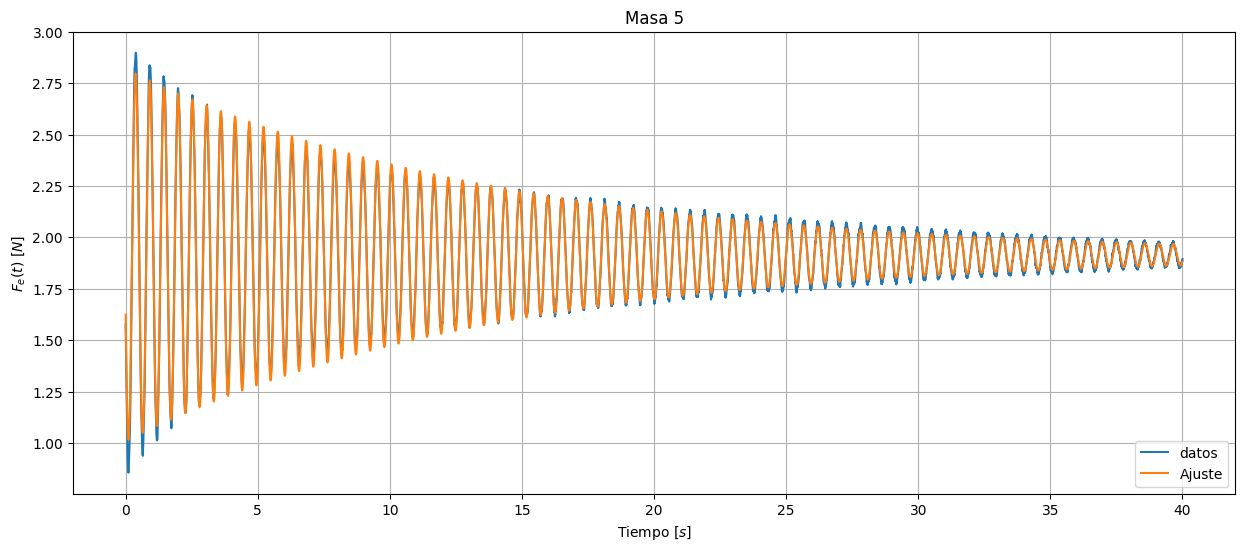

In [619]:
#Importamos los datos
newtons_ = np.array(fuerzas('p3m5')[1])
tiempos_ = np.array(fuerzas('p3m5')[0])

#Condiciones iniciales
Fa = 1.15
Fo = masas_promedios_p3[4] + masa_resor
gamma = 0.3
w = 0.7
phi = 0

#Utilizamos Curvefit
popt, pcov = curve_fit(FAmort, tiempos_, newtons_, p0=[Fa, Fo, gamma, w, phi])

#Obtengo las incertesas
pcov = np.sqrt(np.diag(pcov))

#Guardamos los datos de curvefit junto con sus errores:
gamma_5 = popt[2]
egamma_5 = pcov[2]
wp_5 = popt[3]
ewp_5 = pcov[3]

#Realizamos un plot
plt.figure(figsize=(15,6))
plt.plot(tiempos_,newtons_, label='datos')
plt.plot(tiempos_, FAmort(tiempos_, popt[0], popt[1], popt[2], popt[3], popt[4]), label='Ajuste')

plt.title('Masa 5')
plt.ylabel(r'$F_e(t)$ $[N]$')
plt.xlabel(r'Tiempo $[s]$')

plt.legend(loc='lower right')
plt.grid()
plt.show()

##### Masa 6

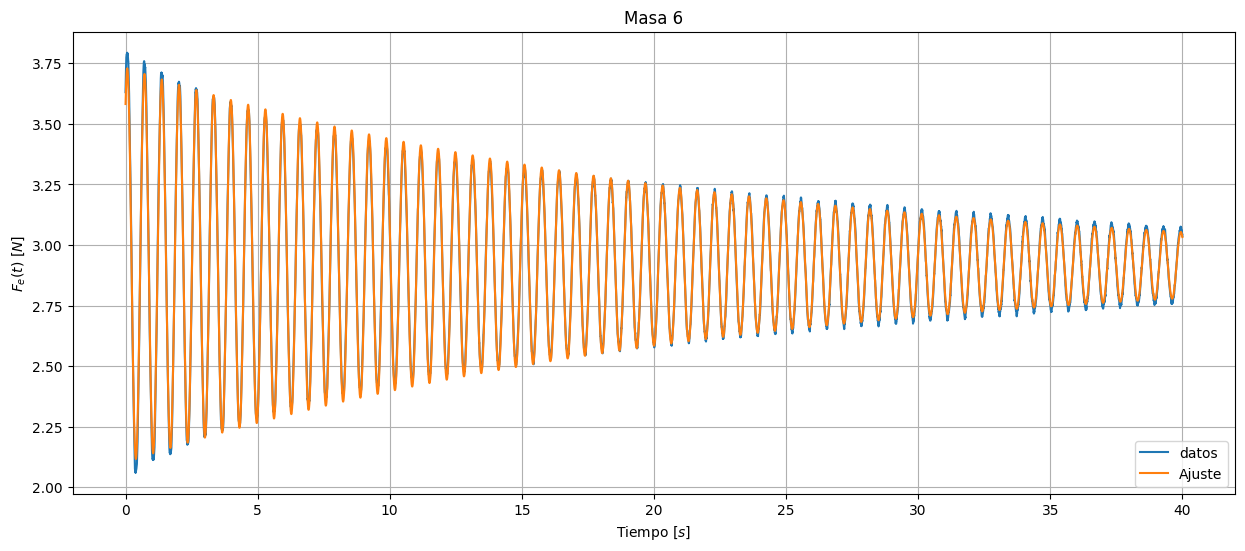

In [620]:
#Importamos los datos
newtons_ = np.array(fuerzas('p3m6')[1])
tiempos_ = np.array(fuerzas('p3m6')[0])

#Condiciones iniciales
Fa = 0.85
Fo = masas_promedios_p3[5] + masa_resor
gamma = 0.3
w = 0.7
phi = np.pi / 2

#Utilizamos Curvefit
popt, pcov = curve_fit(FAmort, tiempos_, newtons_, p0=[Fa, Fo, gamma, w, phi])

#Obtengo las incertesas
pcov = np.sqrt(np.diag(pcov))

#Guardamos los datos de curvefit junto con sus errores:
gamma_6 = popt[2]
egamma_6 = pcov[2]
wp_6 = popt[3]
ewp_6 = pcov[3]

#Realizamos un plot
plt.figure(figsize=(15,6))
plt.plot(tiempos_,newtons_, label='datos')
plt.plot(tiempos_, FAmort(tiempos_, popt[0], popt[1], popt[2], popt[3], popt[4]), label='Ajuste')

plt.title('Masa 6')
plt.ylabel(r'$F_e(t)$ $[N]$')
plt.xlabel(r'Tiempo $[s]$')

plt.legend(loc='lower right')
plt.grid()
plt.show()

##### Masa 7


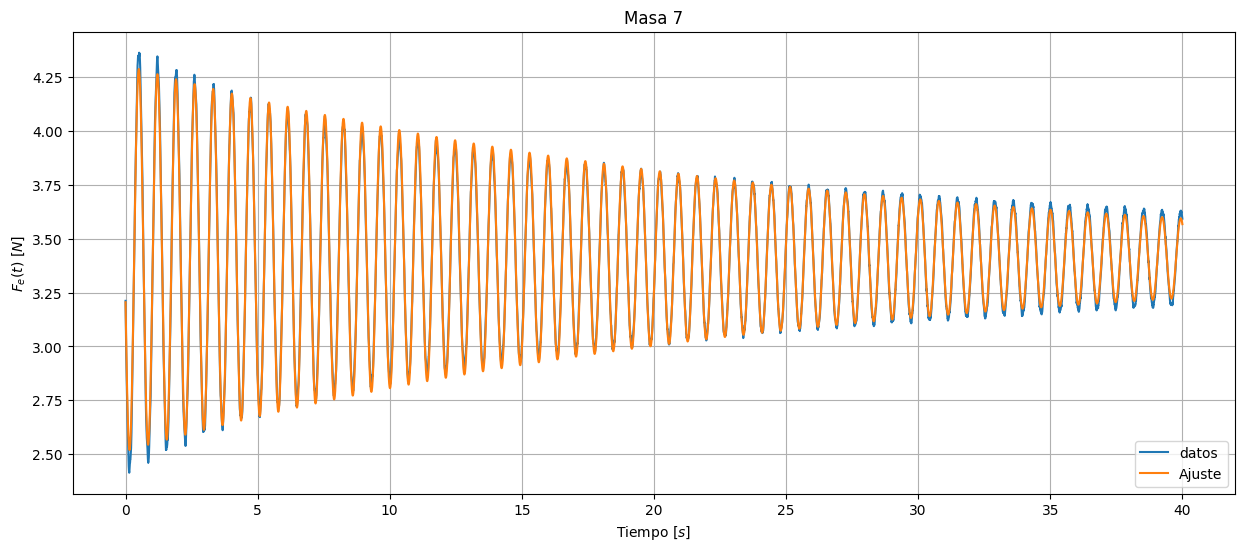

In [621]:
#Importamos los datos
newtons_ = np.array(fuerzas('p3m7')[1])
tiempos_ = np.array(fuerzas('p3m7')[0])

#Condiciones iniciales
Fa = 1.2
Fo = masas_promedios_p3[5] + masa_resor
gamma = 0.3
w = 0.7
phi = 0

#Utilizamos Curvefit
popt, pcov = curve_fit(FAmort, tiempos_, newtons_, p0=[Fa, Fo, gamma, w, phi])

#Obtengo las incertesas
pcov = np.sqrt(np.diag(pcov))

#Guardamos los datos de curvefit junto con sus errores:
gamma_7 = popt[2]
egamma_7 = pcov[2]
wp_7 = popt[3]
ewp_7 = pcov[3]

#Realizamos un plot
plt.figure(figsize=(15,6))
plt.plot(tiempos_,newtons_, label='datos')
plt.plot(tiempos_, FAmort(tiempos_, popt[0], popt[1], popt[2], popt[3], popt[4]), label='Ajuste')

plt.title('Masa 7')
plt.ylabel(r'$F_e(t)$ $[N]$')
plt.xlabel(r'Tiempo $[s]$')

plt.legend(loc='lower right')
plt.grid()
plt.show()

Guardamos en listas los valores de $\gamma$ y $\omega'$ y sus incertezas

In [622]:
#Valores
gamma_ajuste = np.array([gamma_1, gamma_2, gamma_3, gamma_4, gamma_5, gamma_6, gamma_7])
omegap_ajuste = np.array([wp_1, wp_2, wp_3, wp_4, wp_5, wp_6, wp_7])

#Incertezas
errgamma_ajuste = np.array([egamma_1, egamma_2, egamma_3, egamma_4, egamma_5, egamma_6, egamma_7])
erromegap_ajuste = np.array([ewp_1, ewp_2, ewp_3, ewp_4, ewp_5, ewp_6, ewp_7])

Calculamos un valor medio para el $\gamma$ y el $\omega'$, y las incertezas

In [623]:
#valores
gammaM_ajuste = np.mean(gamma_ajuste)
omegapM_ajuste = np.mean(omegap_ajuste)

#Incertezas
errgammaM_ajuste = np.mean(errgamma_ajuste)
erromegapM_ajuste = np.mean(erromegap_ajuste)

### Obtenemos el valor de $k$

A través de la ecuación $_{(4)}$ podemos llegar a la siguiente relación y hallar $k$<br><br>
$k=m_{tot}(\frac{\gamma^2}{4}+\omega^2)$

Calculo $m_{tot}$

In [624]:
m_tot = np.mean(masas_promedios_p3) + masa_resor

#Calculo el error de m_tot
em_tot = np.std(masas_promedios_p3)

La defino como funcion:

In [625]:
kp3 = m_tot*(gammaM_ajuste**2/4+omegapM_ajuste**2)
print(kp3)

34.295346282878114


Calculo el error de k:

In [626]:
mtot, gamma, wp = sp.symbols('mtot gamma wp')
k3 = (mtot)*(gamma**2/4+wp**2)

#Calculo las derivadas y las evaluo
valores = {
    mtot: np.mean(masas_promedios_p3 + masa_resor),
    gamma: gammaM_ajuste,
    wp: omegapM_ajuste
}
dk_dm = derivada_parcial(mtot, k, valores)
dk_dg = derivada_parcial(gamma, k, valores)
dk_dwp = derivada_parcial(wp, k, valores)

#Calculamos el error de k
radicando = dk_dm**2 * em_tot**2 + dk_dg**2 * errgammaM_ajuste**2 + dk_dwp**2 * erromegapM_ajuste**2
ek3 = np.sqrt(float(radicando))

### Obtenemos el valor de $b$

Luego de conseguir los gammas, consideramos la siguiente relacion:  <br><br>
$γ(m)=\frac{b}{m}$

Definimos en funcion $\gamma:$

In [627]:
def gammaM(m,b): return b / (m + masa_resor)

Realizamos un plot de $\gamma(m_i)$

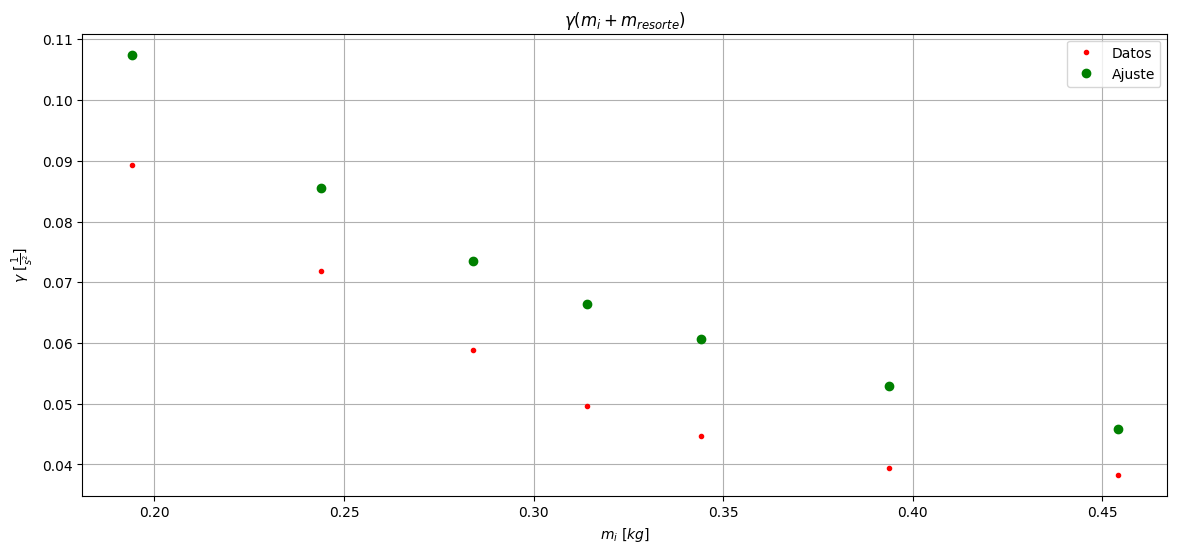

In [628]:
#Utilizamos Curvefit
popt,pcov= curve_fit(gammaM, masas_promedios_p3 + masa_resor, gamma_ajuste)

#Obtengo el valor de b y su incerteza
b = popt[0]
error_b = np.sqrt(np.diag(pcov[0]))
#grafico gammas vs masas 
plt.figure(figsize=(14,6))
plt.plot(masas_promedios_p3 + masa_resor, gamma_ajuste, 'r.', label='Datos')
plt.plot(masas_promedios_p3 + masa_resor, gammaM(masas_promedios_p3, popt[0]), 'go', label='Ajuste')

plt.title(r'$\gamma(m_i + m_{resorte})$')
plt.ylabel(r'$\gamma$ [$\frac{1}{s^2}$]')
plt.xlabel(r'$m_i$ $[kg]$')

plt.grid()
plt.legend(loc='upper right')
plt.show()

## Resultados

$b=(0.0208 ± 0.0008)$

$K=(30 ± 9)\frac{N}{m}$

Coeficiente de Pearson

In [629]:
coef_person(7, (masas_promedios_p3 + masa_resor), gamma_ajuste)

0.9346240789119057